![](https://miro.medium.com/max/3840/1*LHuN1tJt-abIpuX14v5M8w.png)

-----------------------------
Notebook stats:
- takes 30 minutes with Kaggle CPU
- notebook for rapid prototyping with 3200Mhz and 3GHz CPU
- Expected to reach hitrate of 80 in validation
- Use 400GB server and uncomment all features for 85% hitrate, mse: 0.2-0.21200
- Neural Network: mse: 0.15?
-----------------------------

This is yet another starter notebook for the [Numerai Signals](https://signals.numer.ai/). 

What we do here includes:

- fetch US stock price data via YFinance API
- merge the data with the Numerai Signals' historical targets
- perform feature engineering (considering stational features)
- modeling with XGBoost
- submit (if you want)

In a kaggle dataset [YFinance Stock Price Data for Numerai Signals](https://www.kaggle.com/code1110/yfinance-stock-price-data-for-numerai-signals), I fetch the stock price data on a daily basis via the YFinance API. So if you are bothered using the API for yourself, just use this dataset (it must be up-to-date).

This content is largely inspired by the following starter.

>End to end notebook for Numerai Signals using completely free data from Yahoo Finance, by Jason Rosenfeld (jrAI).

https://colab.research.google.com/drive/1ECh69C0LDCUnuyvEmNFZ51l_276nkQqo#scrollTo=tTBUzPep2dm3

Alright, let's get it started!

In [1]:
!ls

2022-06-18.log	   full_data.parquet.zip	   ns-93pct-hit_321.ipynb
full_data.parquet  ns-85pct2pctCorr-hit_321.ipynb


# Libraries
Let's import what we need...

In [2]:
!pip install numerapi
!pip install neptune-client neptune-xgboost sklearn

import numerapi

In [3]:
!pip install xgboost
#==1.3.0.post0
!pip install matplotlib_venn
!pip3 install pyarrow
#!conda install pyarrow

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import pathlib
from tqdm.auto import tqdm
import joblib
import json
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from multiprocessing import Pool, cpu_count
import time
import requests as re
from datetime import datetime
from dateutil.relativedelta import relativedelta, FR

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2, venn3
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('seaborn-colorblind')

import warnings
warnings.simplefilter('ignore')

from sklearn import preprocessing

In [5]:
import neptune.new as neptune
from neptune.new.integrations.xgboost import NeptuneCallback
neptune_switch = 0 #0 is off
if neptune_switch == 1:
    run = neptune.init(
        project="develuse/Signals",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwM2Q3YWQ5MC0zZDA2LTRlOTgtOWRmMC1lNzc0NjIwYjUwZTgifQ==",
    )  # your credentials

# Config
A simple config and logging setup.

In [6]:
today = datetime.now().strftime('%Y-%m-%d')
today

'2022-06-18'

In [7]:
# config class
class CFG:
    """
    Set FETCH_VIA_API = True if you want to fetch the data via API.
    Otherwise we use the daily-updated one in the kaggle dataset (faster).
    """
    INPUT_DIR = './'
    OUTPUT_DIR = './'
    FETCH_VIA_API = False
    SEED = 46
    DEBUG = False # True, test mode using small set of tickers

In [8]:
# Logging is always nice for your experiment:)
def init_logger(log_file='train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = init_logger(log_file=f'{CFG.OUTPUT_DIR}/{today}.log')
logger.info('Start Logging...')

Start Logging...


# Setup Numerai API
First of all, let's set up the numerai signals API. 

We can do many things with this API: 

- get a ticker map (between yfinance data and numerai historical targets)
- get the historical targets
- get your model slot name and model_id (if private key and secret key are provided)
- submit

(well, maybe more)

## Get Tickers for Numerai Signals
Let's first get the ticker map.

In [9]:
napi = numerapi.SignalsAPI()
logger.info('numerai api setup!')

numerai api setup!
2022-06-18 21:52:24,583 INFO __main__: numerai api setup!


In [12]:
# read in list of active Signals tickers which can change slightly era to era
internet=1
if internet==1: #1: internet available
    eligible_tickers = pd.Series(napi.ticker_universe(), name='ticker') 
    logger.info(f"Number of eligible tickers: {len(eligible_tickers)}")

Number of eligible tickers: 5171
2022-06-18 21:53:16,363 INFO __main__: Number of eligible tickers: 5171


In [13]:
# read in yahoo to numerai ticker map, still a work in progress, h/t wsouza and 
# this tickermap is a work in progress and not guaranteed to be 100% correct
if internet==1:
    ticker_map = pd.read_csv('https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_ticker_map_w_bbg.csv')
    ticker_map = ticker_map[ticker_map.bloomberg_ticker.isin(eligible_tickers)]
else:
    ticker_map = pd.read_parquet('ticker_map.parquet')
numerai_tickers = ticker_map['ticker']
yfinance_tickers = ticker_map['yahoo']
logger.info(f"Number of eligible tickers in map: {len(ticker_map)}")


Number of eligible tickers in map: 5171
2022-06-18 21:53:17,413 INFO __main__: Number of eligible tickers in map: 5171


In [14]:
print(ticker_map.shape)
ticker_map.head()

(5171, 3)


,ticker,bloomberg_ticker,yahoo
0,000060 KS,000060 KS,000060.KS
1,000080 KS,000080 KS,000080.KS
2,000100 KS,000100 KS,000100.KS
3,000120 KS,000120 KS,000120.KS
4,000270 KS,000270 KS,000270.KS


In [ ]:
# numerai_universe = 'https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/universe/latest.csv'
# latest_universe = pd.read_csv(numerai_universe)

# print(latest_universe.shape)
# latest_universe

This ticker map is necessary for a successful submission if you use yfinance data.

# Load Stock Price Data
Now is the time to get the stock price data, fetched via the [YFiance API](https://pypi.org/project/yfinance/).

The good thing with this API is that it is free of charge.

The bad thing with this API is that the data is often not complete.

For a better quality of stock price data, you might want to try out purchasing one from [Quandl](https://www.quandl.com/data/EOD-End-of-Day-US-Stock-Prices/documentation?anchor=overview).

This is another starter using Quandl data:
https://forum.numer.ai/t/signals-plugging-in-the-data-from-quandl/2431

This is of course wonderful, but if you are a beginner, why not just start with a free one?

In [15]:
# If you want to fetch the data on your own, you can use this function...

def fetch_yfinance(ticker_map, start='2002-12-01'):
    """
    # fetch yfinance data
    :INPUT:
    - ticker_map : Numerai eligible ticker map (pd.DataFrame)
    - start : date (str)
    
    :OUTPUT:
    - full_data : pd.DataFrame ('date', 'ticker', 'close', 'raw_close', 'high', 'low', 'open', 'volume')
    """
    
    # ticker map
    numerai_tickers = ticker_map['ticker']
    yfinance_tickers = ticker_map['yahoo']

    # fetch
    raw_data = yfinance.download(
        yfinance_tickers.str.cat(sep=' '), 
        start=start, 
        threads=True
    ) 
    
    # format
    cols = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    full_data = raw_data[cols].stack().reset_index()
    full_data.columns = ['date', 'ticker', 'close', 'raw_close', 'high', 'low', 'open', 'volume']
    full_data['date'] = pd.to_datetime(full_data['date'], format='%Y-%m-%d').dt.strftime('%Y%m%d').astype(int)
    
    # map yfiance ticker to numerai tickers
    full_data['ticker'] = full_data.ticker.map(
        dict(zip(yfinance_tickers, numerai_tickers))
    )
    return full_data

In [16]:
%%time

if CFG.FETCH_VIA_API: # fetch data via api
    logger.info('Fetch data via API...may take some time...')
    !pip install yfinance==0.1.62
    !pip install simplejson
    import yfinance
    import simplejson
    
    df = fetch_yfinance(ticker_map, start='2002-12-01')
else: # loading from the kaggle dataset (https://www.kaggle.com/code1110/yfinance-stock-price-data-for-numerai-signals)
    logger.info('Load data from the kaggle dataset...')
#     df = pd.read_csv(pathlib.Path(f'{CFG.INPUT_DIR}/full_data.csv'))
    df = pd.read_parquet(pathlib.Path(f'{CFG.INPUT_DIR}/full_data.parquet'))
    #df = pd.read_parquet('../317/full_data_yahoo_2003_enh317.pqt')

print(df.shape)
df.head(3)

Load data from the kaggle dataset...
2022-06-18 21:53:24,643 INFO __main__: Load data from the kaggle dataset...


(20451152, 8)
CPU times: user 2.49 s, sys: 2.02 s, total: 4.51 s
Wall time: 3.67 s


,ticker,date,close,raw_close,high,low,open,volume
0,000060 KS,20020103,534.924255,1248.795166,1248.795166,1248.795166,1248.795166,0.0
1,000060 KS,20020104,566.944397,1323.546997,1363.121460,1213.617798,1275.178223,3937763.0
2,000060 KS,20020107,636.635315,1486.242188,1521.419434,1323.546997,1345.532837,3078118.0


In [18]:
df.tail(3)

,ticker,date,close,raw_close,high,low,open,volume
20451149,ZZZ.,20220615,25.639999,25.639999,25.709999,24.740000,25.100000,156200.0
20451150,ZZZ.,20220616,24.340000,24.340000,25.100000,24.219999,25.100000,116600.0
20451151,ZZZ.,20220617,24.660000,24.660000,24.850000,24.160000,24.370001,78800.0


## Load Targets for Numerai Signals
For a supervised machine learning, we need a target label. That is available in the Numerai Signals, so we can just fetch it.

Note that there are 2 target columns: 'target' and 'target_20d'. 'target' is often referred as 'target_4d', which is a shorter target.

Values for target_4d and target_20d become available after they have resolved, 11 and 33 days respectively from round open. target_20d takes longer to resolve, and so the most recent dates will have a value of NaN for target_20d, while target_4d will not.

target_20d is what your Signal is evaluated against for scoring and payouts, so we use 'target_20d' in this starter notebook.

In [19]:
%%time

def read_numerai_signals_targets():
    # read in Signals targets
#     numerai_targets = 'https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_train_val.csv'
    numerai_targets = 'https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_train_val_bbg.csv'
    targets = pd.read_csv(numerai_targets)
    
    # to datetime int
    targets['friday_date'] = pd.to_datetime(targets['friday_date'].astype(str), format='%Y-%m-%d').dt.strftime('%Y%m%d').astype(int)
    
#     # train, valid split
#     train_targets = targets.query('data_type == "train"')
#     valid_targets = targets.query('data_type == "validation"')
    
    return targets
if internet==1:
    targets = read_numerai_signals_targets()
else:
    targets = pd.read_parquet('targets.parquet')

CPU times: user 33 s, sys: 1.86 s, total: 34.9 s
Wall time: 2min 9s


In [20]:
# convert to numerai ticker, if the target ticker is not
if 'bloomberg_ticker' in targets.columns.values.tolist():
    targets['ticker'] = targets['bloomberg_ticker'].map(
        dict(zip(ticker_map['bloomberg_ticker'], ticker_map['ticker']))
    )
if 'bloomberg_ticker' not in targets.columns.values.tolist():
    targets['bloomberg_ticker'] = targets['ticker'].map(
        dict(zip(ticker_map['ticker'], ticker_map['bloomberg_ticker']))
    )
    
print(targets.shape, targets['friday_date'].min(), targets['friday_date'].max())
targets.head()

(4631921, 6) 20030131 20220603


,bloomberg_ticker,friday_date,data_type,target_4d,target_20d,ticker
0,000270 KS,20030131,train,0.50,0.50,000270 KS
1,000810 KS,20030131,train,0.50,0.50,000810 KS
2,000830 KS,20030131,train,0.50,0.50,NaN
3,002790 KS,20030131,train,0.25,0.25,NaN
4,003450 KS,20030131,train,0.25,0.50,NaN


In [21]:
targets.tail()

,bloomberg_ticker,friday_date,data_type,target_4d,target_20d,ticker
4631916,ZURN SW,20220603,validation,0.25,NaN,ZURN SW
4631917,ZV IM,20220603,validation,0.50,NaN,ZV IM
4631918,ZWS US,20220603,validation,0.50,NaN,ZWS
4631919,ZYXI US,20220603,validation,1.00,NaN,ZYXI
4631920,ZZZ CN,20220603,validation,0.50,NaN,ZZZ.


**************************************************
2022-06-18 21:55:57,847 INFO __main__: **************************************************
train target: 3,270 numerai tickers , 9,590 bloomberg tickers (friday_date: 20030131 - 20121228)
2022-06-18 21:55:58,087 INFO __main__: train target: 3,270 numerai tickers , 9,590 bloomberg tickers (friday_date: 20030131 - 20121228)
**************************************************
2022-06-18 21:55:58,475 INFO __main__: **************************************************
validation target: 5,149 numerai tickers , 10,021 bloomberg tickers (friday_date: 20130104 - 20220603)
2022-06-18 21:55:58,753 INFO __main__: validation target: 5,149 numerai tickers , 10,021 bloomberg tickers (friday_date: 20130104 - 20220603)


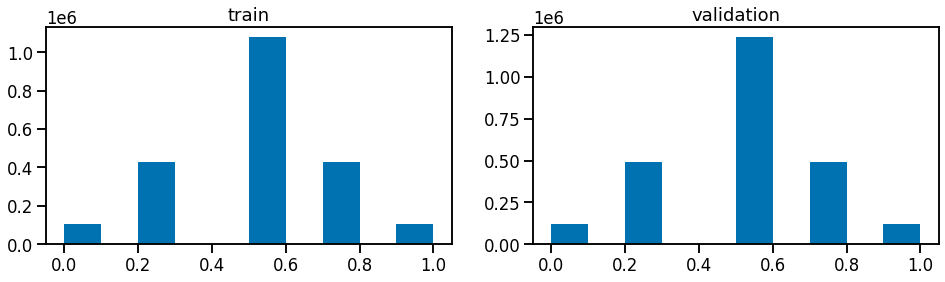

In [22]:
# there are train and validation...
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax = ax.flatten()

for i, data_type in enumerate(['train', 'validation']):
    # slice
    targets_ = targets.query(f'data_type == "{data_type}"')
    logger.info('*' * 50)
    logger.info('{} target: {:,} numerai tickers , {:,} bloomberg tickers (friday_date: {} - {})'.format(
        data_type, 
        targets_['ticker'].nunique(),
        targets_['bloomberg_ticker'].nunique(),
        targets_['friday_date'].min(),
        targets_['friday_date'].max(),
    ))
    
    # plot target
#     ax[i].hist(targets_['target'])
    ax[i].hist(targets_['target_20d'])
    ax[i].set_title(f'{data_type}')

In [23]:
# target relations
d = pd.crosstab(
    targets['target_4d']
    , targets['target_20d']
)
d['sum'] = d.values.sum(axis=1)
for i, f in enumerate(d.columns):
    d[f] = d.apply(lambda row : 100*row[f]/row['sum'], axis=1)
d.drop(columns=['sum'], inplace=True)

print('target transition matrix (%)')
d.astype(int).style.background_gradient(cmap='viridis', axis=1)

target transition matrix (%)


target_20d,0.000000,0.250000,0.500000,0.750000,1.000000
target_4d,,,,,
0.000000,28,37,25,6,2
0.250000,7,32,46,10,2
0.500000,2,18,57,18,2
0.750000,2,10,47,32,7
1.000000,2,5,25,38,28


The target looks exactly like the one from the Numerai Tournament, where both features and targets are given to the participants.

Also note that the train-validation split is based on time (i.e., Time-Series Split):

- train friday_date: 20030131 ~ 20121228
- validation friday_date: 20130104 ~ 

## Check Ticker Overlaps
Let's see if we have enough overlap of tickers between our yfiance stock data and the numerai targets. We need at least 5 tickers for submission.

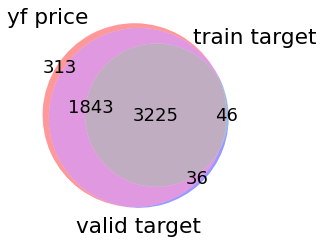

In [24]:
# ticker overlap
venn3(
    [
        set(df['ticker'].unique().tolist())
        , set(targets.query('data_type == "train"')['ticker'].unique().tolist())
        , set(targets.query('data_type == "validation"')['ticker'].unique().tolist())
    ],
    set_labels=('yf price', 'train target', 'valid target')
)

Ah, yeah, not bad, I guess? 

Here I only use our stock price data which have ticker overlaps such that we can build a supervised machine learning model.

In [25]:
# select target-only tickers
df = df.loc[df['ticker'].isin(targets['ticker'])].reset_index(drop=True)

print('{:,} tickers: {:,} records'.format(df['ticker'].nunique(), len(df)))

5,068 tickers: 19,459,590 records


As I mentioned earlier, the yfiance stock data is not complete. Let's see if we have enough records per ticker.

In [26]:
record_per_ticker = df.groupby('ticker')['date'].nunique().reset_index().sort_values(by='date')
record_per_ticker

,ticker,date
512,357780 KS,1
471,319660 KS,2
394,272290 KS,2
399,278280 KS,2
467,317330 KS,2
...,...,...
3396,MGROS TI,5281
5033,YATAS TI,5281
1483,ASELS TI,5281
4331,SISE TI,5281


count    5068.000000
mean     3839.698106
std      1703.096101
min         1.000000
25%      2268.000000
50%      5033.000000
75%      5151.000000
max      5281.000000
Name: date, dtype: float64


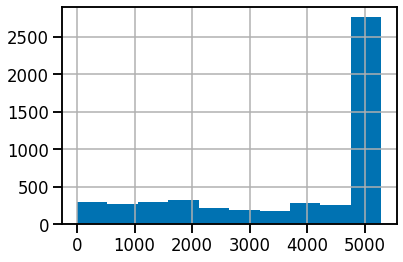

In [27]:
record_per_ticker['date'].hist()
print(record_per_ticker['date'].describe())

There are unfortunately some tickers where the number of records is small. 

Here I only use tickers with more than 1,000 records.

In [28]:
if CFG.DEBUG: # debug mode, using small set of data
    tickers_with_records = record_per_ticker.query('date >= 5030')['ticker'].values
else:
    tickers_with_records = record_per_ticker.query('date >= 5030')['ticker'].values
df = df.loc[df['ticker'].isin(tickers_with_records)].reset_index(drop=True)
print(df.shape)
df = df#[-14057147:]
print(df.shape)
print(df.tail())
print('Here, we use {:,} tickers: {:,} records'.format(df['ticker'].nunique(), len(df)))

(13099343, 8)
(13099343, 8)
           ticker      date       close   raw_close        high         low  \
13099338  ZURN SW  20220613  417.299988  417.299988  419.500000  415.000000   
13099339  ZURN SW  20220614  419.100006  419.100006  421.600006  415.000000   
13099340  ZURN SW  20220615  426.100006  426.100006  431.700012  422.399994   
13099341  ZURN SW  20220616  412.299988  412.299988  422.500000  408.399994   
13099342  ZURN SW  20220617  408.500000  408.500000  413.799988  405.700012   

                open    volume  
13099338  415.899994  417399.0  
13099339  417.200012  402521.0  
13099340  424.399994  520047.0  
13099341  421.000000  553902.0  
13099342  413.500000  892338.0  
Here, we use 2,544 tickers: 13,099,343 records


# Feature Engineering
Yeah finally machine learning part!

Here we generate sets of stock price features. There are some caveats to be aware of:

- **No Leak**: we cannot use a feature which uses the future information (this is a forecasting task!)
- **Stationaly features**: Our features have to work whenever (scales must be stationaly over the periods of time)

The implementation of the feature engineering is derived from [J-Quants Tournament](https://japanexchangegroup.github.io/J-Quants-Tutorial/#anchor-2.7). Although this content is in Japanese, I believe this is one of the best resources for feature engineering in the finance domain. 

Also I add the RSI and MACD (PPO) features as a bonus:D

We generate features per ticker repeatedly. To accelerate the process, we use the parallel processing.

In [29]:
# first, fix date column in the yfiance stock data to be friday date (just naming along with numerai targets)
df['friday_date'] = df['date'].apply(lambda x : int(str(x).replace('-', '')))
del record_per_ticker, d, ticker_map


In [30]:
# recent friday date?
recent_friday = datetime.now() + relativedelta(weekday=FR(-1))
recent_friday = int(recent_friday.strftime('%Y%m%d'))
print(f'Most recent Friday: {recent_friday}')

Most recent Friday: 20220617


In [31]:
# in case no recent friday is available...prep the second last
recent_friday2 = datetime.now() + relativedelta(weekday=FR(-2))
recent_friday2 = int(recent_friday2.strftime('%Y%m%d'))
print(f'Second most recent Friday: {recent_friday2}')

Second most recent Friday: 20220610


In [32]:
# fix market-not-open-on-Friday problem
if CFG.DEBUG == False:
    if np.sum(df['friday_date'] == recent_friday) < 4000:
        previous_tickers = set(df.query('friday_date == @recent_friday2')['ticker']) 
        current_tickers = set(df.query('friday_date == @recent_friday')['ticker'])
        missing_df = pd.DataFrame()
        missing_df['ticker'] = list(previous_tickers - current_tickers)
        for d in ['date', 'friday_date']:
            missing_df[d] = recent_friday
        
        # concat
        orig_shape = df.shape
        df = pd.concat([df, missing_df]).sort_values(by=['ticker', 'friday_date']).fillna(method='ffill')
        del missing_df
        print('Resolving missing tickers due to market-not-open-on-friday issue: df shape {} => {}'.format(
            orig_shape, df.shape
        ))    

Resolving missing tickers due to market-not-open-on-friday issue: df shape (13099343, 9) => (13099343, 9)


In [33]:
def reduce_mem_usage(df, verbose=False):
    start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage before optimization 2 is: {:.2f} MB'.format(start_mem))
    #print("The dataframe 2 has {} columns.".format(df.shape[1]))
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    start_mem = end_mem
    #print('Memory usage after optimization 2 is: {:.2f} MB'.format(end_mem))
    #print("The reduced dataframe 2 has {} columns.".format(df.shape[1]))                
    return df
gc.collect()

3807

In [34]:
# technical indicators
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)
def log_return2(series, periods=2):
    return np.log(series).diff(periods=periods)   
def log_return3(series, periods=3):
    return np.log(series).diff(periods=periods)   
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

def add_poly(df, features, deg=2):
    """
    add polynomial features
    """
    poly = preprocessing.PolynomialFeatures(deg)
    emb = poly.fit_transform(df[features].values)
    for i in range(len(features), emb.shape[1]):
        df[f'poly_{i+1}'] = emb[:, i]
    return df
def RSI(close: pd.DataFrame, period: int = 14) -> pd.Series:
    # https://gist.github.com/jmoz/1f93b264650376131ed65875782df386
    """See source https://github.com/peerchemist/finta
    and fix https://www.tradingview.com/wiki/Talk:Relative_Strength_Index_(RSI)
    Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements.
    RSI oscillates between zero and 100. Traditionally, and according to Wilder, RSI is considered overbought when above 70 and oversold when below 30.
    Signals can also be generated by looking for divergences, failure swings and centerline crossovers.
    RSI can also be used to identify the general trend."""

    delta = close.diff()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    _gain = up.ewm(com=(period - 1), min_periods=period).mean()
    _loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()

    RS = _gain / _loss
    return pd.Series(100 - (100 / (1 + RS)))

def EMA1(x, n):
    """
    https://qiita.com/MuAuan/items/b08616a841be25d29817
    """
    a= 2/(n+1)
    return pd.Series(x).ewm(alpha=a).mean()

def MACD(close : pd.DataFrame, span1=12, span2=26, span3=9):
    """
    Compute MACD
    # https://www.learnpythonwithrune.org/pandas-calculate-the-moving-average-convergence-divergence-macd-for-a-stock/
    """
    exp1 = EMA1(close, span1)
    exp2 = EMA1(close, span2)
    macd = 100 * (exp1 - exp2) / exp2
    signal = EMA1(macd, span3)

    return macd, signal
def POW(x, n):
    """
    Return Exponential power of series and other, element-wise (binary operator pow).
    # https://pandas.pydata.org/docs/reference/api/pandas.Series.pow.html
    """

    return pd.Series(x).pow(n, fill_value=0)

def STD(x):
    """

    # https://pandas.pydata.org/docs/reference/api/pandas.Series.std.html
    """

    return pd.Series(x).std()

def SKEW(x):
    """

    # https://pandas.pydata.org/docs/reference/api/pandas.Series.skew.html
    """

    return pd.Series(x).skew()
def feature_engineering(ticker='ZEAL DC', df=df):
    """
    feature engineering
    
    :INPUTS:
    - ticker : numerai ticker name (str)
    - df : yfinance dataframe (pd.DataFrame)
    
    :OUTPUTS:
    - feature_df : feature engineered dataframe (pd.DataFrame)
    """
    # init
    keys = ['friday_date', 'ticker']
    feature_df = df.query(f'ticker == "{ticker}"')
    
    # price features
    new_feats = []
    for i, f in enumerate(['close', ]):
        for x in [10, 20, 40, 60, 80,90,100,110,120]:
            # return
            feature_df[f"{f}_return_{x}days"] = feature_df[
                f
            ].pct_change(x)

            # volatility
            feature_df[f"{f}_volatility_{x}days"] = (
                np.log1p(feature_df[f])
                .pct_change()
                .rolling(x)
                .std()
            )
 
            # volatility change
            feature_df[f"{f}_volatility_{x}days"] = (
                np.log1p(feature_df[f])
                .pct_change()
                .pct_change()
                .rolling(x)
                .std()
            )       
            # kairi mean
            feature_df[f"{f}_MA_gap_{x}days"] = feature_df[f] / (
                feature_df[f].rolling(x).mean()
            )
            
            # features to use
            new_feats += [
                f"{f}_return_{x}days", 
                f"{f}_volatility_{x}days",
                f"{f}_MA_gap_{x}days",
                         ]
    feature_df["return_1month"] = feature_df["close"].pct_change(20)
    feature_df["return_2month"] = feature_df["close"].pct_change(40)
    feature_df["return_3month"] = feature_df["close"].pct_change(60)
    feature_df["volatility_1month"] = (
        np.log(feature_df["close"]).diff().rolling(20).std()
    )
    feature_df["volatility_2month"] = (
        np.log(feature_df["close"]).diff().rolling(40).std()
    )
    feature_df["volatility_3month"] = (
        np.log(feature_df["close"]).diff().rolling(60).std()
    )
    feature_df["MA_gap_1month"] = feature_df["close"] / (
        feature_df["close"].rolling(20).mean()
    )
    feature_df["MA_gap_2month"] = feature_df["close"] / (
        feature_df["close"].rolling(40).mean()
    )
    feature_df["MA_gap_3month"] = feature_df["close"] / (
        feature_df["close"].rolling(60).mean()
    )
          
    # TODO add PCA 
    # RSI
    feature_df['RSI'] = RSI(feature_df['close'], 14)
    feature_df['RSI20'] = RSI(feature_df['close'], 20)
    feature_df['RSI40'] = RSI(feature_df['close'], 40)
    feature_df['RSI60'] = RSI(feature_df['close'], 60)
    feature_df['RSI80'] = RSI(feature_df['close'], 80)
    feature_df['RSI100'] = RSI(feature_df['close'], 100)
    feature_df['RSI120'] = RSI(feature_df['close'], 120)
    feature_df['RSI140'] = RSI(feature_df['close'], 140)
    
    # MACD
    macd, macd_signal = MACD(feature_df['close'], 12, 26, 9) 
    feature_df['MACD'] = macd
    feature_df['MACD_signal'] = macd_signal
    macd0, macd_signal0 = MACD(feature_df['close'], 10, 24, 8) 
    feature_df['MACD0'] = macd0
    feature_df['MACD_signal0'] = macd_signal0
    macd2, macd_signal2 = MACD(feature_df['close'], 20, 48, 16) 
    feature_df['MACD2'] = macd2
    feature_df['MACD_signal2'] = macd_signal2
    macd3, macd_signal3 = MACD(feature_df['close'], 30, 72, 24) 
    feature_df['MACD3'] = macd3
    feature_df['MACD_signal3'] = macd_signal3
    macd4, macd_signal4 = MACD(feature_df['close'], 40, 96, 32) 
    feature_df['MACD4'] = macd4
    feature_df['MACD_signal4'] = macd_signal4


    feature_df['Close'] = feature_df["close"]
    feature_df['Open'] = feature_df["open"]  
    feature_df['Low'] = feature_df["low"]
    feature_df['High'] = feature_df["high"] 
    feature_df['Volume'] = feature_df["volume"]
    feature_df['LRET'] = log_return(feature_df["close"])
    feature_df['LRET_OPEN'] = log_return(feature_df["open"])    
    feature_df['LRET_LOW'] = log_return(feature_df["low"])
    feature_df['LRET_HIGH'] = log_return(feature_df["high"])    
    feature_df['VOL_LRET'] = log_return(feature_df["volume"])
    fvol = feature_df["close"]*feature_df["volume"]    
    feature_df['FVOL_LRET'] = log_return(fvol)
    feature_df["fvol"] = fvol  
    # fill nan
    feature_df.fillna(method='ffill', inplace=True) # safe fillna method for a forecasting task
    feature_df.fillna(method='bfill', inplace=True) # just in case ... making sure no nan
    #clean DF
    feature_df = feature_df.replace([np.inf, -np.inf, np.nan], -20000)  
    feature_df.dropna(inplace=True)
        
    # Polynomial features
    add_poly(feature_df, ['close','volume','FVOL_LRET','VOL_LRET','LRET','fvol'], deg=4)  
    #sklearn.preprocessing.PolynomialFeatures   
    
    for i, f in enumerate(['Volume', ]):
        for x in [2,18,19,20,21,22,23,24,25,26,27,28,29,
                  30,31,32,33,34,35,36,37,38,
                  39,40,41,42,43,44,45,46,47,48,49,51,52,53,54,
                  55,57,60,80,89,100,144 
                 ]:
            # return
            feature_df[f"vol_{f}_return_{x}days"] = feature_df[
                f
            ].pct_change(x)
        
            # return absolute
            feature_df[f"vol_{f}_return_abs_{x}days"] = feature_df[
                f
            ].pct_change(x).abs() 
            
            # volatility
            feature_df[f"vol_{f}_volatility_{x}days"] = (
                np.log1p(feature_df[f])
                .pct_change()
                .rolling(x)
                .std()
            )
            
            # kairi mean
            feature_df[f"vol_{f}_MA_gap_{x}days"] = feature_df[f] / (
                feature_df[f].rolling(x).mean()
            )
            
            # features to use
            new_feats += [
                f"vol_{f}_return_{x}days", 
            
                f"vol_{f}_return_abs_{x}days",
            
                f"vol_{f}_volatility_{x}days",

                f"vol_{f}_MA_gap_{x}days",           
                ]    
            
    for i, f in enumerate(['LRET', ]):
        for x in [2,20,21,22,23,24,25,26,27,28,29,18,19,
                  30,31,32,33,34,35,36,37,38,
                  39,40,41,42,43,44,45,46,47,48,49,51,52,53,54,
                  55,57,60,80,89,100,144
                 ]: #extendend round 301; reduced round 302 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,
            #TODO make similar iterator with jhtalib (salvage Joost code)
            # return
            feature_df[f"{f}lret_return_{x}days"] = feature_df[
                f
            ].pct_change(x)
        
            # return absolute
            feature_df[f"{f}lret_return_abs_{x}days"] = feature_df[
                f
            ].pct_change(x).abs() 
            
            # volatility
            feature_df[f"{f}lret_volatility_{x}days"] = (
                np.log1p(feature_df[f])
                .pct_change()
                .rolling(x)
                .std()
            )
            
            # kairi mean
            feature_df[f"{f}lret_MA_gap_{x}days"] = feature_df[f] / (
                feature_df[f].rolling(x).mean()
            )
            
            # features to use
            new_feats += [
                f"{f}lret_return_{x}days", 
            
                f"{f}lret_return_abs_{x}days",
            
                f"{f}lret_volatility_{x}days",

                f"{f}lret_MA_gap_{x}days", 
                ]     
          
    for i, f in enumerate(['VOL_LRET', ]):
        for x in [2,20,21,22,23,24,25,26,27,28,29,18,19,
                  30,31,32,33,34,35,36,37,38,
                  39,40,41,42,43,44,45,46,47,48,49,51,52,53,54,
                  55,57,60,80,89,100,144 
                 ]:
            # return
            feature_df[f"vol_{f}lret_return_{x}days"] = feature_df[
                f
            ].pct_change(x)
        
            # return absolute
            feature_df[f"vol_{f}lret_return_abs_{x}days"] = feature_df[
                f
            ].pct_change(x).abs() 
            
            # volatility
            feature_df[f"vol_{f}lret_volatility_{x}days"] = (
                np.log1p(feature_df[f])
                .pct_change()
                .rolling(x)
                .std()
            )
            
            # kairi mean
            feature_df[f"vol_{f}lret_MA_gap_{x}days"] = feature_df[f] / (
                feature_df[f].rolling(x).mean()
            )
            
            # features to use
            new_feats += [
                f"vol_{f}lret_return_{x}days", 
            
                f"vol_{f}lret_return_abs_{x}days",
            
                f"vol_{f}lret_volatility_{x}days",

                f"vol_{f}lret_MA_gap_{x}days",           
                ]    
  
    for i, f in enumerate(['FVOL_LRET', ]):
        for x in [2,20,21,22,23,24,25,26,27,28,29, 18,19,
                  30,31,32,33,34,35,36,37,38,
                  39,40,41,42,43,44,45,46,47,48,49,51,52,53,54,
                  55,57,60,80,89,100,144 
                 ]:
            # return
            feature_df[f"fvol_{f}lret_return_{x}days"] = feature_df[
                f
            ].pct_change(x)
        
            # return absolute
            feature_df[f"fvol_{f}lret_return_abs_{x}days"] = feature_df[
                f
            ].pct_change(x).abs() 
            
            # volatility
            feature_df[f"fvol_{f}lret_volatility_{x}days"] = (
                np.log1p(feature_df[f])
                .pct_change()
                .rolling(x)
                .std()
            )
            
            # kairi mean
            feature_df[f"fvol_{f}lret_MA_gap_{x}days"] = feature_df[f] / (
                feature_df[f].rolling(x).mean()
            )
            
            # features to use
            new_feats += [
                f"fvol_{f}lret_return_{x}days", 
            
                f"fvol_{f}lret_return_abs_{x}days",
            
                f"fvol_{f}lret_volatility_{x}days",

                f"fvol_{f}lret_MA_gap_{x}days",           
                ]  
            
    for i, f in enumerate(['fvol', ]):
        for x in [18,19,20,21,22,23,24,25,26,27,28,29,
                  30,31,32,33,34,35,36,37,38,
                  39,40,41,42,43,44,45,46,47,48,49,51,52,53,54,
                  55,57,60,80,89,100,144 
                 ]:
            # return
            feature_df[f"fvol_{f}_return_{x}days"] = feature_df[
                f
            ].pct_change(x)
        
            # return absolute
            feature_df[f"fvol_{f}_return_abs_{x}days"] = feature_df[
                f
            ].pct_change(x).abs() 
            
            # volatility
            feature_df[f"fvol_{f}_volatility_{x}days"] = (
                np.log1p(feature_df[f])
                .pct_change()
                .rolling(x)
                .std()
            )
            
            # kairi mean
            feature_df[f"fvol_{f}_MA_gap_{x}days"] = feature_df[f] / (
                feature_df[f].rolling(x).mean()
            )
            
            # features to use
            new_feats += [
                f"fvol_{f}_return_{x}days", 
            
                f"fvol_{f}_return_abs_{x}days",
            
                f"fvol_{f}_volatility_{x}days",

                f"fvol_{f}_MA_gap_{x}days",           
                ]  

    # Financial volume
    feature_df['fvol_shift1'] = feature_df.Volume.shift(periods=1) * feature_df.Close.shift(periods=1)
    feature_df['fvol_shift2'] = feature_df.Volume.shift(periods=2) * feature_df.Close.shift(periods=2)
    feature_df['fvol_shift3'] = feature_df.Volume.shift(periods=3) * feature_df.Close.shift(periods=3)
    feature_df['fvol_shift4'] = feature_df.Volume.shift(periods=4) * feature_df.Close.shift(periods=4)
    feature_df['fvol_shift5'] = feature_df.Volume.shift(periods=5) * feature_df.Close.shift(periods=5)
    feature_df['fvol_shift6'] = feature_df.Volume.shift(periods=6) * feature_df.Close.shift(periods=6)
    feature_df['fvol_shift7'] = feature_df.Volume.shift(periods=7) * feature_df.Close.shift(periods=7)
    feature_df['fvol_shift8'] = feature_df.Volume.shift(periods=8) * feature_df.Close.shift(periods=8)
    feature_df['fvol_shift9'] = feature_df.Volume.shift(periods=9) * feature_df.Close.shift(periods=9)
    feature_df['fvol_shift10'] = feature_df.Volume.shift(periods=10) * feature_df.Close.shift(periods=10)
    
    """
    # RSI
    feature_df['fvol_RSI3'] = RSI(feature_df['fvol'], 3)
    feature_df['fvol_RSI3_shift1'] = RSI(feature_df['fvol'], 3).shift(periods=1)
    feature_df['fvol_RSI4'] = RSI(feature_df['fvol'], 4)
    feature_df['fvol_RSI5'] = RSI(feature_df['fvol'], 5)
    feature_df['fvol_RSI6'] = RSI(feature_df['fvol'], 6)
    feature_df['fvol_RSI7'] = RSI(feature_df['fvol'], 7)
    feature_df['fvol_RSI8'] = RSI(feature_df['fvol'], 8)
    feature_df['fvol_RSI9'] = RSI(feature_df['fvol'], 9)
    feature_df['fvol_RSI10'] = RSI(feature_df['fvol'], 10)
    feature_df['fvol_RSI11'] = RSI(feature_df['fvol'], 11)
    feature_df['fvol_RSI12'] = RSI(feature_df['fvol'], 12)
    feature_df['fvol_RSI13'] = RSI(feature_df['fvol'], 13)
    """
    feature_df['fvol_RSI'] = RSI(feature_df['fvol'], 14)

    # MACD
    macd, macd_signal = MACD(feature_df['fvol'], 10, 24, 8) 
    feature_df['fvol_MACD'] = macd
    feature_df['fvol_MACD_signal'] = macd_signal

    # Price exponentional power
    feature_df['fvol_POW2'] = POW(feature_df['fvol'], 2)    
    feature_df['fvol_POW3'] = POW(feature_df['fvol'], 3)
    feature_df['fvol_POW3_shift1'] = POW(feature_df['fvol'], 3).shift(periods=1) 
    #feature_df['fvol_POW4'] = POW(feature_df['fvol'], 4)
    
    # EMA
    # EMA
    feature_df['lretEMA3'] = EMA1(feature_df['Close'], 3)
    feature_df['lretEMA3_shift1'] = feature_df['lretEMA3'].shift(periods=1)    
    feature_df['lretEMA4'] = EMA1(feature_df['Close'], 4)
    feature_df['lretEMA5'] = EMA1(feature_df['Close'], 5) 
    feature_df['lretEMA6'] = EMA1(feature_df['Close'], 6) 
    feature_df['lretEMA7'] = EMA1(feature_df['Close'], 7) 
    feature_df['lretEMA8'] = EMA1(feature_df['Close'], 8) 
    feature_df['lretEMA9'] = EMA1(feature_df['Close'], 9) 
    feature_df['lretEMA10'] = EMA1(feature_df['Close'], 10) 
    feature_df['lretEMA11'] = EMA1(feature_df['Close'], 11) 
    feature_df['lretEMA12'] = EMA1(feature_df['Close'], 12) 
    feature_df['lretEMA13'] = EMA1(feature_df['Close'], 13) 
    feature_df['lretEMA14'] = EMA1(feature_df['Close'], 14) 
    feature_df['lretEMA15'] = EMA1(feature_df['Close'], 15) 
    feature_df['lretEMA16'] = EMA1(feature_df['Close'], 16) 
    feature_df['lretEMA20'] = EMA1(feature_df['Close'], 20) 
    feature_df['lretEMA40'] = EMA1(feature_df['Close'], 40) 
    feature_df['lretEMA60'] = EMA1(feature_df['Close'], 60) 
    feature_df['lretEMA80'] = EMA1(feature_df['Close'], 80) 
    
    """
    feature_df['fvol_EMA3'] = EMA1(feature_df['fvol'], 3)
    feature_df['fvol_EMA3_shift1'] = feature_df['fvol_EMA3'].shift(periods=1)    
    feature_df['fvol_EMA4'] = EMA1(feature_df['fvol'], 4)
    feature_df['fvol_EMA5'] = EMA1(feature_df['fvol'], 5) 
    feature_df['fvol_EMA6'] = EMA1(feature_df['fvol'], 6) 
    feature_df['fvol_EMA7'] = EMA1(feature_df['fvol'], 7) 
    feature_df['fvol_EMA8'] = EMA1(feature_df['fvol'], 8) 
    feature_df['fvol_EMA9'] = EMA1(feature_df['fvol'], 9) 
    feature_df['fvol_EMA10'] = EMA1(feature_df['fvol'], 10) 
    feature_df['fvol_EMA11'] = EMA1(feature_df['fvol'], 11) 
    feature_df['fvol_EMA12'] = EMA1(feature_df['fvol'], 12) 
    feature_df['fvol_EMA13'] = EMA1(feature_df['fvol'], 13) 
    feature_df['fvol_EMA14'] = EMA1(feature_df['fvol'], 14) 
    feature_df['fvol_EMA15'] = EMA1(feature_df['fvol'], 15) 
    feature_df['fvol_EMA16'] = EMA1(feature_df['fvol'], 16)
    """
    feature_df['fvol_EMA20'] = EMA1(feature_df['fvol'], 20) 
    feature_df['fvol_EMA40'] = EMA1(feature_df['fvol'], 40) 
    feature_df['fvol_EMA60'] = EMA1(feature_df['fvol'], 60) 
    feature_df['fvol_EMA80'] = EMA1(feature_df['fvol'], 80)
    
    # Standard Deviation
    feature_df['fvol_STD'] = STD(feature_df['fvol'])   
    """
    feature_df['fvol_STD_shift1'] = feature_df['fvol_STD'].shift(periods=1)
    feature_df['fvol_STD_shift2'] = feature_df['fvol_STD'].shift(periods=2)
    feature_df['fvol_STD_shift3'] = feature_df['fvol_STD'].shift(periods=3)
    feature_df['fvol_STD_shift4'] = feature_df['fvol_STD'].shift(periods=4)    
    feature_df['fvol_STD_shift5'] = feature_df['fvol_STD'].shift(periods=5)  
    feature_df['fvol_STD_shift6'] = feature_df['fvol_STD'].shift(periods=6)  
    feature_df['fvol_STD_shift10'] = feature_df['fvol_STD'].shift(periods=10)  
    feature_df['fvol_STD_shift19'] = feature_df['fvol_STD'].shift(periods=19)  
    feature_df['fvol_STD_shift20'] = feature_df['fvol_STD'].shift(periods=20)
    """  
    feature_df['fvol_STD_shift21'] = feature_df['fvol_STD'].shift(periods=21)    
    
    # Skew
    feature_df['fvol_SKEW'] = SKEW(feature_df['fvol'])   
    feature_df['fvol_SKEW_shift1'] = feature_df['fvol_SKEW'].shift(periods=1)              
            
    feature_df['LRETLRET'] = log_return(feature_df["LRET"])            

    feature_df['HL_sprd'] = np.log((feature_df["high"] - feature_df["low"]) / feature_df["close"])
    feature_df['CO_sprd'] = (feature_df["close"] - feature_df["open"]) / feature_df["open"]
    feature_df['logVolume'] = np.log(feature_df["volume"])
    mean_price = feature_df[['open', 'high', 'low', 'close']].mean(axis=1)
    feature_df['mean_price'] =  mean_price
    median_price = feature_df[['open', 'high', 'low', 'close']].median(axis=1)
    feature_df['median_price'] = median_price
    feature_df['barMean'] = feature_df[['open', 'high', 'low', 'close']].mean(axis=1) #little bit of importance
    feature_df["barMedian"] = feature_df[["open", "high", "low", "close"]].median(axis=1) #little bit of importance    
    feature_df['high2mean'] = feature_df['high'] / mean_price
    feature_df['low2mean'] = feature_df['low'] / mean_price
    feature_df['high2median'] = feature_df['high'] / median_price
    feature_df['low2median'] = feature_df['low'] / median_price
    feature_df['volume2vol+1'] = feature_df['volume'] / (feature_df['volume'] + 1)
    feature_df["opensubclose"] = feature_df["open"] - feature_df["close"]
    feature_df['Upper_Shadow'] = feature_df['high'] - np.maximum(feature_df['close'], feature_df['open'])
    feature_df['Lower_Shadow'] = np.minimum(feature_df['close'], feature_df['Open']) - feature_df['low']
    feature_df['hlco_ratio'] = (feature_df['High'] - feature_df['low'])/(feature_df['close']-feature_df['open'])  
    feature_df["Close/Open"] = feature_df["close"] / feature_df["open"] 
    feature_df["Close-Open"] = feature_df["close"] - feature_df["open"]
    feature_df["Close-Open_shift1"] = feature_df["close"].shift(periods=1) - feature_df["open"]    
    feature_df["High-Low"] = feature_df["high"] - feature_df["low"]  
    feature_df['High/Mean'] = feature_df['high'] / feature_df['mean_price']
    feature_df['Low/Mean'] = feature_df['low'] / feature_df['mean_price']
    feature_df['Volume/Close'] = feature_df['volume'] / (feature_df['close'])
 
    #LRET
    feature_df['Close'] = feature_df["LRET"]
    feature_df['Open'] = feature_df["LRET_OPEN"]
    feature_df['High'] = feature_df["LRET_HIGH"]
    feature_df['Low'] = feature_df["LRET_LOW"]
    feature_df['Volume'] = feature_df["VOL_LRET"]     
    
    #feature_df["LRET_shift1"] = feature_df['LRET'].shift(periods=1)  
    #feature_df["LRET_shift2"] = feature_df['LRET'].shift(periods=2)  
    #feature_df["LRET_shift3"] = feature_df['LRET'].shift(periods=3)  
    #feature_df["LRET_shift4"] = feature_df['LRET'].shift(periods=4)  
    feature_df["LRET_shift6"] = feature_df['LRET'].shift(periods=6)  

    #feature_df["LRET_shift5"] = feature_df['LRET'].shift(periods=6)  
    #feature_df["LRET_shift7"] = feature_df['LRET'].shift(periods=7)  
    #feature_df["LRET_shift8"] = feature_df['LRET'].shift(periods=8)  
    #feature_df["LRET_shift9"] = feature_df['LRET'].shift(periods=9)  
    #feature_df["LRET_shift10"] = feature_df['LRET'].shift(periods=10)  
    #feature_df["LRET_shift11"] = feature_df['LRET'].shift(periods=11)  
    #feature_df["LRET_shift12"] = feature_df['LRET'].shift(periods=12)  
    #feature_df["LRET_shift13"] = feature_df['LRET'].shift(periods=13)  
    feature_df["LRET_shift14"] = feature_df['LRET'].shift(periods=14)  
    feature_df["LRET_shift15"] = feature_df['LRET'].shift(periods=15)  
    #feature_df["LRET_shift16"] = feature_df['LRET'].shift(periods=16)  
    #feature_df["LRET_shift17"] = feature_df['LRET'].shift(periods=17)  
    #feature_df["LRET_shift18"] = feature_df['LRET'].shift(periods=18)  
    feature_df["LRET_shift21"] = feature_df['LRET'].shift(periods=21)

    # RSI 
    #feature_df['RSI3'] = RSI(feature_df['Close'], 3)
    #feature_df['RSI3_shift1'] = RSI(feature_df['Close'], 3).shift(periods=1)
    #feature_df['RSI4'] = RSI(feature_df['Close'], 4)
    #feature_df['RSI5'] = RSI(feature_df['Close'], 5)
    #feature_df['RSI6'] = RSI(feature_df['Close'], 6)
    #feature_df['RSI7'] = RSI(feature_df['Close'], 7)
    #feature_df['RSI8'] = RSI(feature_df['Close'], 8)
    #feature_df['RSI9'] = RSI(feature_df['Close'], 9)
    #feature_df['RSI10'] = RSI(feature_df['Close'], 10)
    #feature_df['RSI11'] = RSI(feature_df['Close'], 11)
    feature_df['RSI12lret'] = RSI(feature_df['Close'], 12)
    #feature_df['RSI13'] = RSI(feature_df['Close'], 13)
    feature_df['RSIlret'] = RSI(feature_df['Close'], 14)
    feature_df['RSI20lret'] = RSI(feature_df['Close'], 20)
    feature_df['RSI40lret'] = RSI(feature_df['Close'], 40)  
    feature_df['RSI60lret'] = RSI(feature_df['Close'], 60) 
    feature_df['RSI80lret'] = RSI(feature_df['Close'], 80)
    feature_df['RSI100lret'] = RSI(feature_df['Close'], 100)    
    feature_df['RSI120lret'] = RSI(feature_df['Close'], 120)        
    # MACD
    macd, macd_signal = MACD(feature_df['Close'], 20, 48, 16) 
    feature_df['MACDlret'] = macd
    feature_df['MACD_signallret'] = macd_signal
    macdlret2, macd_signallret2 = MACD(feature_df['Close'], 10, 24, 8) 
    feature_df['MACD2lret'] = macdlret2
    feature_df['MACD_signal2lret'] = macd_signallret2
    #macd3, macd_signal3 = MACD(feature_df['Close'], 5, 12, 4) 
    #feature_df['MACD3'] = macd3
    #feature_df['MACD_signal3'] = macd_signal3  
    """
    # Price exponentional power
    feature_df['POW05'] = POW(feature_df['Close'], 0.5)  
    feature_df['POW2'] = POW(feature_df['Close'], 2)    
    feature_df['POW3'] = POW(feature_df['Close'], 3)
    feature_df['POW3_shift1'] = POW(feature_df['Close'], 3).shift(periods=1) 
    feature_df['POW4'] = POW(feature_df['Close'], 4)
    feature_df['POW5'] = POW(feature_df['Close'], 5)    
    
    # Volume exponentional power
    feature_df['VPOW05'] = POW(feature_df['Volume'], 0.5)
    feature_df['VPOW2'] = POW(feature_df['Volume'], 2)
    feature_df['VPOW3'] = POW(feature_df['Volume'], 3)    
    feature_df['VPOW4'] = POW(feature_df['Volume'], 4) 
    feature_df['VPOW5'] = POW(feature_df['Volume'], 5) 
    """
    # set of lret formulas
    feature_df['HL_sprdlret'] = np.log((feature_df["High"] - feature_df["Low"]) / feature_df["Close"])
    feature_df['CO_sprdlret'] = (feature_df["Close"] - feature_df["Open"]) / feature_df["Open"]
    feature_df['logVolumelret'] = np.log(feature_df["Volume"])
    mean_price = feature_df[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    feature_df['mean_pricelret'] =  mean_price
    median_price = feature_df[['Open', 'High', 'Low', 'Close']].median(axis=1)
    feature_df['median_pricelret'] = median_price
    feature_df['barMeanlret'] = feature_df[['Open', 'High', 'Low', 'Close']].mean(axis=1) #little bit of importance
    feature_df["barMedianlret"] = feature_df[["Open", "High", "Low", "Close"]].median(axis=1) #little bit of importance       
    feature_df['upper_shadow1lret'] = feature_df['High'] / feature_df[['Close', 'Open']].max(axis=1)
    feature_df['lower_shadow1lret'] = feature_df[['Close', 'Open']].min(axis=1) / feature_df['Low']
    feature_df['open2closelret'] = feature_df['Close'] / feature_df['Open']
    feature_df['high2lowlret'] = feature_df['High'] / feature_df['Low']
    feature_df['Meanlret'] = feature_df['mean_pricelret']
  
    """
    for i, f in enumerate(['Close', ]):
        for x in [18,19,20,21,22,23,24,25,26,27,28,29,
                  30,31,32,33,34,35,36,37,38,
                  #39,40,41,42,43,44,45,46,47,48,49,51,52,53,54,
                  #55,57,89,100,144
                 ]: #extendend round 301; reduced round 302 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,
            #TODO make similar iterator with jhtalib (salvage Joost code)
            # return
            feature_df[f"{f}_return_{x}days"] = feature_df[
                f
            ].pct_change(x)
        
            # return absolute
            feature_df[f"{f}_return_abs_{x}days"] = feature_df[
                f
            ].pct_change(x).abs() 
            
            # volatility
            feature_df[f"{f}_volatility_{x}days"] = (
                np.log1p(feature_df[f])
                .pct_change()
                .rolling(x)
                .std()
            )
            
            # kairi mean
            feature_df[f"{f}_MA_gap_{x}days"] = feature_df[f] / (
                feature_df[f].rolling(x).mean()
            )
            
            # features to use
            new_feats += [
                f"{f}_return_{x}days", 
            
                f"{f}_return_abs_{x}days",
            
                f"{f}_volatility_{x}days",

                f"{f}_MA_gap_{x}days", 
                ]     
    """

    # Price and volume
    #feature_df['Close'] = feature_df["close"]
    #feature_df['Open'] = feature_df["open"]
    #feature_df['High'] = feature_df["high"]
    #feature_df['Low'] = feature_df["low"]
    #feature_df['Volume'] = feature_df["volume"]     
    feature_df['LRET'] = log_return(feature_df["Close"])
    # RSI
    feature_df['RSI3'] = RSI(feature_df['Close'], 3)
    feature_df['RSI3_shift1'] = RSI(feature_df['Close'], 3).shift(periods=1)
    feature_df['RSI4'] = RSI(feature_df['Close'], 4)
    feature_df['RSI5'] = RSI(feature_df['Close'], 5)
    feature_df['RSI6'] = RSI(feature_df['Close'], 6)
    feature_df['RSI7'] = RSI(feature_df['Close'], 7)
    feature_df['RSI8'] = RSI(feature_df['Close'], 8)
    feature_df['RSI9'] = RSI(feature_df['Close'], 9)
    feature_df['RSI10'] = RSI(feature_df['Close'], 10)
    feature_df['RSI11'] = RSI(feature_df['Close'], 11)
    feature_df['RSI12'] = RSI(feature_df['Close'], 12)
    feature_df['RSI13'] = RSI(feature_df['Close'], 13)
    feature_df['RSI_'] = RSI(feature_df['Close'], 14)

    # Volume RSI
    feature_df['VRSI3'] = RSI(feature_df['Volume'], 3)
    feature_df['VRSI3_shift1'] = feature_df['VRSI3'].shift(periods=1)    
    feature_df['VRSI4'] = RSI(feature_df['Volume'], 4)
    feature_df['VRSI5'] = RSI(feature_df['Volume'], 5)
    feature_df['VRSI6'] = RSI(feature_df['Volume'], 6)
    feature_df['VRSI7'] = RSI(feature_df['Volume'], 7)
    feature_df['VRSI8'] = RSI(feature_df['Volume'], 8)
    feature_df['VRSI9'] = RSI(feature_df['Volume'], 9)
    feature_df['VRSI10'] = RSI(feature_df['Volume'], 10)
    feature_df['VRSI11'] = RSI(feature_df['Volume'], 11)
    feature_df['VRSI12'] = RSI(feature_df['Volume'], 12)
    feature_df['VRSI13'] = RSI(feature_df['Volume'], 13)
    feature_df['VRSI'] = RSI(feature_df['Volume'], 14)
    
    # MACD
    macd, macd_signal = MACD(feature_df['Close'], 10, 24, 8) 
    feature_df['MACD_'] = macd
    feature_df['MACD_signal_'] = macd_signal
    macd, macd_signal = MACD(feature_df['Close'], 20, 48, 16) 
    feature_df['MACD_2'] = macd
    feature_df['MACD_signal_2'] = macd_signal
    macd, macd_signal = MACD(feature_df['Close'], 30, 72, 24) 
    feature_df['MACD_3'] = macd
    feature_df['MACD_signal_3'] = macd_signal
    macd, macd_signal = MACD(feature_df['Close'], 40, 96, 32) 
    feature_df['MACD_4'] = macd
    feature_df['MACD_signal_4'] = macd_signal

    
    # Price exponentional power
    feature_df['lretPOW05'] = POW(feature_df['Close'], 0.5)  
    feature_df['lretPOW2'] = POW(feature_df['Close'], 2)    
    feature_df['lretPOW3'] = POW(feature_df['Close'], 3)
    feature_df['lretPOW3_shift1'] = POW(feature_df['Close'], 3).shift(periods=1) 
    #feature_df['POW4'] = POW(feature_df['Close'], 4)
    #feature_df['POW5'] = POW(feature_df['Close'], 5)    
    
    # Volume exponentional power
    feature_df['lretVPOW05'] = POW(feature_df['Volume'], 0.5)
    feature_df['lretVPOW2'] = POW(feature_df['Volume'], 2)
    #feature_df['VPOW3'] = POW(feature_df['Volume'], 3)    
    #feature_df['VPOW4'] = POW(feature_df['Volume'], 4) 
    #feature_df['VPOW5'] = POW(feature_df['Volume'], 5) 
   
    # EMA
    feature_df['EMA3'] = EMA1(feature_df['Close'], 3)
    feature_df['EMA3_shift1'] = feature_df['EMA3'].shift(periods=1)    
    feature_df['EMA4'] = EMA1(feature_df['Close'], 4)
    feature_df['EMA5'] = EMA1(feature_df['Close'], 5) 
    feature_df['EMA6'] = EMA1(feature_df['Close'], 6) 
    feature_df['EMA7'] = EMA1(feature_df['Close'], 7) 
    feature_df['EMA8'] = EMA1(feature_df['Close'], 8) 
    feature_df['EMA9'] = EMA1(feature_df['Close'], 9) 
    feature_df['EMA10'] = EMA1(feature_df['Close'], 10) 
    feature_df['EMA11'] = EMA1(feature_df['Close'], 11) 
    feature_df['EMA12'] = EMA1(feature_df['Close'], 12) 
    feature_df['EMA13'] = EMA1(feature_df['Close'], 13) 
    feature_df['EMA14'] = EMA1(feature_df['Close'], 14) 
    feature_df['EMA15'] = EMA1(feature_df['Close'], 15) 
    feature_df['EMA16'] = EMA1(feature_df['Close'], 16) 
    feature_df['EMA20'] = EMA1(feature_df['Close'], 20) 
    feature_df['EMA40'] = EMA1(feature_df['Close'], 40) 
    feature_df['EMA60'] = EMA1(feature_df['Close'], 60) 
    feature_df['EMA80'] = EMA1(feature_df['Close'], 80) 
    
    # Volume EMA
    feature_df['lretVEMA3'] = EMA1(feature_df['Volume'], 3)
    feature_df['lretVEMA3_shift1'] = feature_df['lretVEMA3'].shift(periods=1)   
    feature_df['lretVEMA4'] = EMA1(feature_df['Volume'], 4)
    feature_df['lretVEMA5'] = EMA1(feature_df['Volume'], 5) 
    feature_df['lretVEMA6'] = EMA1(feature_df['Volume'], 6) 
    feature_df['lretVEMA7'] = EMA1(feature_df['Volume'], 7) 
    feature_df['lretVEMA8'] = EMA1(feature_df['Volume'], 8) 
    feature_df['lretVEMA9'] = EMA1(feature_df['Volume'], 9) 
    feature_df['lretVEMA10'] = EMA1(feature_df['Volume'], 10) 
    
    # Standard Deviation
    feature_df['lretSTD'] = STD(feature_df['Close'])  
    feature_df['lretSTD_shift1'] = feature_df['lretSTD'].shift(periods=1)
    feature_df['lretSTD_shift2'] = feature_df['lretSTD'].shift(periods=2)
    feature_df['lretSTD_shift3'] = feature_df['lretSTD'].shift(periods=3)
    feature_df['lretSTD_shift4'] = feature_df['lretSTD'].shift(periods=4)    
    feature_df['lretSTD_shift5'] = feature_df['lretSTD'].shift(periods=5)  
    feature_df['lretSTD_shift6'] = feature_df['lretSTD'].shift(periods=6)  
    feature_df['lretSTD_shift10'] = feature_df['lretSTD'].shift(periods=10)  
    feature_df['lretSTD_shift19'] = feature_df['lretSTD'].shift(periods=19)  
    feature_df['lretSTD_shift20'] = feature_df['lretSTD'].shift(periods=20)
    feature_df['lretSTD_shift21'] = feature_df['lretSTD'].shift(periods=21) 
    
    # Volume standard deviation
    feature_df['VSTD'] = STD(feature_df['Volume'])   
    feature_df['VSTD_shift1'] = feature_df['VSTD'].shift(periods=1)   
    
    # Skew
    feature_df['SKEW'] = SKEW(feature_df['Close'])   
    feature_df['SKEW_shift1'] = feature_df['SKEW'].shift(periods=1)   
    feature_df['SKEW_shift2'] = feature_df['SKEW'].shift(periods=2)    
    
    # Volume Skew
    feature_df['VSKEW'] = SKEW(feature_df['Volume'])
    feature_df['VSKEW_shift1'] = feature_df['VSKEW'].shift(periods=1) 
    
    # Price
    feature_df['Close']
    
    # Volume
    feature_df['Volume'] 
     
    mean_price = feature_df[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    feature_df['lretmean_price'] =  mean_price  
    feature_df['HL_sprd'] = np.log((feature_df["High"] - feature_df["Low"]) / feature_df["Close"])
    feature_df['CO_sprd'] = (feature_df["Close"] - feature_df["Open"]) / feature_df["Open"]
    #feature_df['logVolume'] = np.log(feature_df["Volume"])
    mean_price = feature_df[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    feature_df['mean_price'] =  mean_price
    median_price = feature_df[['Open', 'High', 'Low', 'Close']].median(axis=1)
    feature_df['median_price'] = median_price
    feature_df['barMean'] = feature_df[['Open', 'High', 'Low', 'Close']].mean(axis=1) #little bit of importance
    feature_df["barMedian"] = feature_df[["Open", "High", "Low", "Close"]].median(axis=1) #little bit of importance    
    feature_df['lretMean'] = feature_df['mean_price']
    feature_df['lrethigh2mean'] = feature_df['High'] / mean_price
    feature_df['lretlow2mean'] = feature_df['Low'] / mean_price
    feature_df['lrethigh2median'] = feature_df['High'] / median_price
    feature_df['lretlow2median'] = feature_df['Low'] / median_price
    feature_df['lretvolume2vol+1'] = feature_df['Volume'] / (feature_df['Volume'] + 1)
    feature_df["lretopensubclose"] = feature_df["Open"] - feature_df["Close"]
    feature_df['lretUpper_Shadow'] = feature_df['High'] - np.maximum(feature_df['Close'], feature_df['Open'])
    feature_df['lretLower_Shadow'] = np.minimum(feature_df['Close'], feature_df['Open']) - feature_df['Low']
    feature_df['lrethlco_ratio'] = (feature_df['High'] - feature_df['Low'])/(feature_df['Close']-feature_df['Open'])  
    feature_df["lretClose/Open"] = feature_df["Close"] / feature_df["Open"] 
    feature_df["lretClose-Open"] = feature_df["Close"] - feature_df["Open"]
    feature_df["lretClose-Open_shift1"] = feature_df["Close"].shift(periods=1) - feature_df["Open"]    
    feature_df["lretHigh-Low"] = feature_df["High"] - feature_df["Low"]  
    feature_df['lretHigh/Mean'] = feature_df['High'] / feature_df['lretMean']
    feature_df['lretLow/Mean'] = feature_df['Low'] / feature_df['lretMean']
    feature_df['lretVolume/Close'] = feature_df['Volume'] / (feature_df['Close'] + 0.01)
    
    feature_df['date2'] = pd.to_datetime(feature_df['date'], format="%Y%m%d")
    times = pd.to_datetime(feature_df["date2"],unit="D",infer_datetime_format=True)
    feature_df["dayofweek"] = times.dt.dayofweek 
    feature_df["day"] = times.dt.day
    feature_df["monthstart"] = times.dt.is_month_start
    feature_df["monthend"] = times.dt.is_month_end
    feature_df["quarterstart"] = times.dt.is_quarter_start
    feature_df["quarterend"] = times.dt.is_quarter_end    
    feature_df["yearstart"] = times.dt.is_year_start# .dt    
    feature_df["yearend"] = times.dt.is_year_end# .dt  
    feature_df["dayofweekday"] = feature_df["dayofweek"]+ feature_df["day"]    
    feature_df["monthstartday"] = feature_df["monthstart"]+ feature_df["day"]
    feature_df["monthendday"] = feature_df["monthend"]+ feature_df["day"]
    feature_df["quarterstartday"] = feature_df["quarterstart"]+ feature_df["day"]
    feature_df["quarterendday"] = feature_df["quarterend"]+ feature_df["day"]
    feature_df["yearstartday"] = feature_df["yearstart"]+ feature_df["day"]
    feature_df["yearendday"] = feature_df["yearend"]+ feature_df["day"]
    feature_df["yearendmonthstart"] = feature_df["yearend"]+ feature_df["monthstart"]    
    feature_df["yearendmonthend"] = feature_df["yearend"]+ feature_df["monthend"]
    feature_df["monthstartdayofweek"] = feature_df["monthstart"]+ feature_df["dayofweek"]
    feature_df["monthenddayofweek"] = feature_df["monthend"]+ feature_df["dayofweek"]
    feature_df["quarterstartdayofweek"] = feature_df["quarterstart"]+ feature_df["dayofweek"]
    feature_df["quarterenddayofweek"] = feature_df["quarterend"]+ feature_df["dayofweek"]
    feature_df["yearstartdayofweek"] = feature_df["yearstart"]+ feature_df["dayofweek"]
    feature_df["yearenddayofweek"] = feature_df["yearend"]+ feature_df["dayofweek"]
    feature_df["yearendquarterstart"] = feature_df["yearend"]+ feature_df["quarterstart"]    
    feature_df["yearendquarterend"] = feature_df["yearend"]+ feature_df["quarterend"]   
    
    feature_df['100returns'] = 100 * feature_df["Close"].pct_change()
    # CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
    feature_df['log_returns'] = np.log(feature_df["Close"]/feature_df["Close"].shift(1))
    feature_df['Vlog_returns'] = np.log(feature_df["Volume"]/feature_df["Volume"].shift(1))    
    feature_df['log_returns2'] = np.log(feature_df["Close"]/feature_df["Close"].shift(2))
    feature_df['Vlog_returns2'] = np.log(feature_df["Volume"]/feature_df["Volume"].shift(2))    
    feature_df['log_returns3'] = np.log(feature_df["Close"]/feature_df["Close"].shift(3))
    feature_df['LRET'] = log_return(feature_df['Close'])
    feature_df['VLRET'] = log_return(feature_df['Volume'])
    feature_df['RVOL'] = realized_volatility(feature_df['LRET'])
    feature_df['RVOL2'] = realized_volatility(feature_df['RVOL'])
    # DROPPING THE 1ST ROW OF DATA 
    # BECAUSE I SHIFTED IT FORWARD TO CALCULATE RETURNS/LOG RETURNS  
    #The Open/High/Low/Close prices are usually very similar and highly correlated to each other. Therefore, instead of keeping all of them in the dataset, I would add 2 more features:
    #feature_df['logVolume'] = np.log(feature_df["Volume"])
    feature_df["barSkew"] = feature_df[["Open", "High", "Low", "Close"]].skew(axis=1)
    feature_df["barKurt"] = feature_df[["Open", "High", "Low", "Close"]].kurt(axis=1)
    feature_df['Mean2'] = feature_df[['Open', 'Close']].mean(axis=1)
    feature_df['EMA3_shift1_2'] = feature_df['EMA3_shift1']**2 
    feature_df['EMA13_2'] = feature_df['EMA13']**2 
    
    # price features
    new_feats += ['HL_sprd','CO_sprd','logVolume','mean_price','median_price','barMean',"barMedian",'high2mean','low2mean','high2median','low2median','volume2vol+1',"opensubclose",'Upper_Shadow','Lower_Shadow','hlco_ratio',"Close/Open","Close-Open","Close-Open_shift1","High-Low",'High/Mean','Low/Mean','Volume/Close',
                  'MACD0','MACD_signal0','MACD2','MACD_signal2','MACD3','MACD_signal3','MACD4','MACD_signal4', 'MACD', 'MACD_signal',
                  'poly_7', 'poly_8', 'poly_9', 'poly_10', 'poly_11', 'poly_12', 'poly_13', 'poly_14', 'poly_15',
                  'poly_16', 'poly_17', 'poly_18', 'poly_19', 'poly_20', 'poly_21', 'poly_22', 'poly_23', 'poly_24', 'poly_25', 'poly_26', 'poly_27', 'poly_28',
                  'poly_29', 'poly_30', 'poly_31', 'poly_33', 'poly_34', 'poly_35', 'poly_36', 'poly_37', 'poly_38', 'poly_39', 'poly_40', 'poly_41', 'poly_42',
                  'poly_43', 'poly_44', 'poly_45', 'poly_46', 'poly_47', 'poly_48', 'poly_49', 'poly_50', 'poly_51', 'poly_52', 'poly_53', 'poly_54', 'poly_55',#'poly_4', 'poly_5', 'poly_6',   
                  'poly_56', 'poly_57', 'poly_58', 'poly_59', 'poly_60', 'poly_61', 'poly_62', 'poly_63', 'poly_64', 'poly_65', 'poly_66', 'poly_67', 'poly_68',
                  'poly_69', 'poly_70', 'poly_71', 'poly_73', 'poly_74', 'poly_75', 'poly_76', 'poly_77', 'poly_78', 'poly_79', 'poly_80', 'poly_81', 'poly_82',
                  'poly_83', 'poly_84', 'poly_85', 'poly_86', 'poly_87', 'poly_88', 'poly_89', 'poly_90', 'poly_91', 'poly_92', 'poly_93', 'poly_94', 'poly_95',
                  'poly_96', 'poly_97', 'poly_98', 'poly_99', 'poly_100', 'poly_101', 'poly_102', 'poly_103', 'poly_104', 'poly_105', 'poly_106', 'poly_107', 'poly_108',
                  'poly_109', 'poly_110', 'poly_111', 'poly_113', 'poly_114', 'poly_115', 'poly_116', 'poly_117', 'poly_118', 'poly_119', 'poly_120', 'poly_121', 'poly_122',
                  'poly_123', 'poly_124', 'poly_125', 'poly_126', 'poly_127', 'poly_128', 'poly_129', 'poly_130', 'poly_131', 'poly_132', 'poly_133', 'poly_134', 'poly_135',
                  #305p11'poly_136', 'poly_137', 'poly_138', 'poly_139', 'poly_140', 'poly_141', 'poly_142', 'poly_143', 'poly_144', 'poly_145', 'poly_146', 'poly_147', 'poly_148',                
                  'RSI5','RSI6','RSI7','RSI8','RSI9','RSI10','RSI11','RSI12','RSI13','RSI','RSI_','RSI20','RSI40','RSI60','RSI80','RSI100','RSI120','RSI140',#'RSI3','RSI3_shift1','RSI4',                    
                  "return_1month","return_2month","return_3month","volatility_1month","volatility_2month","volatility_3month","MA_gap_1month","MA_gap_2month","MA_gap_3month",
                  'LRET_OPEN','LRET_LOW','LRETLRET','VOL_LRET','FVOL_LRET','LRET_HIGH',                
                  'RSI12lret','RSIlret','RSI20lret','RSI40lret','RSI60lret','RSI80lret','RSI100lret','RSI120lret',#'RSI13','RSI3','RSI3_shift1','RSI4','RSI5','RSI6','RSI7','RSI8','RSI9','RSI10','RSI11',
                  'LRET_shift6','LRET_shift14','LRET_shift15','LRET_shift21',#'LRET_shift2','LRET_shift16','LRET_shift17','LRET_shift18','LRET_shift19','LRET_shift3','LRET_shift4','LRET_shift5','LRET_shift1','LRET_shift7','LRET_shift8','LRET_shift9','LRET_shift10','LRET_shift11','LRET_shift12','LRET_shift13',                  
                  'EMA3','EMA3_shift1','EMA13','EMA4','EMA5','EMA6','EMA7','EMA8','EMA9','EMA10','EMA11','EMA12','EMA14','EMA15','EMA16','EMA20','EMA40','EMA60','EMA80',       
                  'VRSI3','VRSI3_shift1','VRSI4','VRSI5','VRSI6','VRSI7','VRSI8','VRSI9','VRSI10','VRSI11','VRSI12','VRSI13','VRSI',
                  #'VEMA3','VEMA3_shift1','VEMA4','VEMA5','VEMA6','VEMA7','VEMA8','VEMA9','VEMA10',
                  #'POW05','POW2','VPOW2','VPOW05','POW3_shift1','POW3',#,'VPOW3''VPOW5','VPOW4','POW4','POW5',lretHL_sprd', 'lretCO_sprd', 'lretmedian_price', 'lretbarMean', 'lretbarMedian'
                  #'VSKEW','VSKEW_shift1','SKEW_shift2',#active 20220606 (truth ambig.. eroor) 'VSKEW_shift1',,'SKEW_shift2'
                  
                  #fvol 
                  'fvol_EMA20','fvol_EMA40','fvol_EMA60','fvol_EMA80',#'fvol_EMA3','fvol_EMA3_shift1','fvol_EMA4','fvol_EMA5','fvol_EMA6','fvol_EMA7','fvol_EMA8','fvol_EMA9','fvol_EMA10','fvol_EMA11','fvol_EMA12','fvol_EMA13','fvol_EMA14','fvol_EMA15','fvol_EMA16',
                  'fvol_shift7',
                  #'fvol_POW2','fvol_POW3','fvol_POW3_shift1',#'fvol_POW4',        
                  'fvol','fvol_shift1','fvol_shift2','fvol_shift3','fvol_shift4','fvol_shift5','fvol_shift6','fvol_shift8','fvol_shift9','fvol_shift10',
                  'fvol_RSI',#'fvol_RSI3','fvol_RSI3_shift1','fvol_RSI4','fvol_RSI5','fvol_RSI6','fvol_RSI7','fvol_RSI8','fvol_RSI9','fvol_RSI10','fvol_RSI11','fvol_RSI12','fvol_RSI13',
                  #'fvol_EMA3','fvol_EMA3_shift1','fvol_EMA4','fvol_EMA5','fvol_EMA6','fvol_EMA7','fvol_EMA8','fvol_EMA9','fvol_EMA10','fvol_EMA11','fvol_EMA12','fvol_EMA13','fvol_EMA14','fvol_EMA15','fvol_EMA16',
                  'fvol_STD_shift21',
                  'fvol_STD',#'fvol_STD_shift1','fvol_STD_shift2','fvol_STD_shift3','fvol_STD_shift4','fvol_STD_shift5','fvol_STD_shift6','fvol_STD_shift10','fvol_STD_shift19','fvol_STD_shift20',
                  'fvol_MACD', 'fvol_MACD_signal',     
                  #'fvol','fvol_shift1','fvol_shift2','fvol_shift3','fvol_shift4','fvol_shift5','fvol_shift6','fvol_shift7','fvol_shift8','fvol_shift9','fvol_shift10',
                  #'fvol_RSI3','fvol_RSI3_shift1','fvol_RSI4','fvol_RSI5','fvol_RSI6','fvol_RSI7','fvol_RSI8','fvol_RSI9','fvol_RSI10','fvol_RSI11','fvol_RSI12','fvol_RSI13','fvol_RSI',  
                  #'fvol_SKEW','fvol_SKEW_shift1',                  
                  'MACD_', 'MACD_signal_','MACD_2', 'MACD_signal_2','MACD_3', 'MACD_signal_3','MACD_4', 'MACD_signal_4',
                  #'Close','Volume',
                  "dayofweek","day","monthstart","monthend","quarterstart","quarterend","yearstart","yearend",
                  "monthstartday","monthendday","quarterstartday","quarterendday","yearendday","yearendmonthstart","yearendmonthend",
                  "yearendquarterstart","yearendquarterend",# "quarterstartdayofweek","quarterenddayofweek","yearstartdayofweek","yearenddayofweek","dayofweekday",     "yearstartday",                             
                  #305p11'100returns',
                  #'logVolume',"barSkew","barKurt",'Mean2',
                  
                  #not used for 74-83%
                  #305p11'log_returns','Vlog_returns','log_returns2','Vlog_returns2','log_returns3','LRET','VLRET','RVOL','RVOL2',                  
                  'lretVEMA3','lretVEMA3_shift1','lretVEMA4','lretVEMA5','lretVEMA6','lretVEMA7','lretVEMA8','lretVEMA9','lretVEMA10',
                  'VSTD','VSTD_shift1','SKEW','SKEW_shift1','VSKEW',
                  'Close','Volume',
                  ##replaced the open high low close with change/lret of those            
                  #'lretPOW05','lretPOW2','lretVPOW2','lretPOW3','lretPOW3_shift1','lretVPOW05',#'lretPOW4','lretPOW5','lretVPOW3','lretVPOW4','lretVPOW5',                  
                  'lretSTD','lretSTD_shift1','lretSTD_shift2','lretSTD_shift3','lretSTD_shift4','lretSTD_shift5','lretSTD_shift6','lretSTD_shift10','lretSTD_shift19','lretSTD_shift20','lretSTD_shift21',
                  'lretEMA3','lretEMA3_shift1','lretEMA13','lretEMA4','lretEMA5','lretEMA6','lretEMA7','lretEMA8','lretEMA9','lretEMA10','lretEMA11','lretEMA12','lretEMA14','lretEMA15','lretEMA16','lretEMA20','lretEMA40','lretEMA60','lretEMA80',                         
                  'MACDlret', 'MACD_signallret','MACD2lret', 'MACD_signal2lret',#'MACD3', 'MACD_signal3', 
                  'HL_sprdlret','CO_sprdlret','logVolumelret','mean_pricelret','median_pricelret','barMeanlret',"barMedianlret",'upper_shadow1lret','lower_shadow1lret','open2closelret','high2lowlret','Meanlret',                                     
                  'lretMean',
                  'lrethigh2mean','lretlow2mean','lrethigh2median','lretlow2median','lretvolume2vol+1',
                  "lretopensubclose",'lretUpper_Shadow','lretLower_Shadow','lrethlco_ratio', 
                  "lretClose/Open","lretClose-Open","lretClose-Open_shift1", "lretHigh-Low", 'lretHigh/Mean','lretLow/Mean',
                  'lretVolume/Close',         
 
                  #higher powers quadratic/cubic
                  #'EMA3_shift1_2',#'EMA4_2','EMA5_2','EMA6_2','EMA7_2','EMA8_2','EMA9_2','EMA10_2','EMA11_2','EMA12_2',
                  #'EMA13_2',                  
                  #'RSI3_2','RSI3_shift1_2','RSI4_2','RSI5_2','RSI6_2','RSI7_2','RSI8_2','RSI9_2','RSI10_2','RSI11_2','RSI12_2','RSI13_2','RSI_2', #same quadratic
                  #'LRET_2','LRET_shift1_2',
                  #'VRSI3_2','VRSI3_shift1_2','VRSI4_2','VRSI5_2','VRSI6_2','VRSI7_2','VRSI8_2','VRSI9_2','VRSI10_2','VRSI11_2','VRSI12_2','VRSI13_2','VRSI_2', #same quadratic
                  #'EMA3_2',

                 ]    
#TODO add mean features from jhtalib   

    # only new feats
    feature_df = feature_df[new_feats + keys]

    # fill nan
    feature_df.fillna(method='ffill', inplace=True) # safe fillna method for a forecasting task
    feature_df.fillna(method='bfill', inplace=True) # just in case ... making sure no nan
    #clean DF
    feature_df = feature_df.replace([np.inf, -np.inf, np.nan], -20000)  
    feature_df.dropna(inplace=True)
    return reduce_mem_usage(feature_df)

def add_features(df):
    # FE with multiprocessing
    tickers = df['ticker'].unique().tolist()
    print('FE for {:,} stocks...using {:,} CPUs...'.format(len(tickers), cpu_count()))
    start_time = time.time()
    with Pool(cpu_count()) as p:
        feature_dfs = list(tqdm(p.imap(feature_engineering, tickers), total=len(tickers)))
    return pd.concat(feature_dfs)

In [35]:
%%time

feature_df = add_features(df)
del df
gc.collect()
#Kaggle CPU:19min52s
#round305 ehmac, run 11 25GB-> 37min51s
#round305p node2: 2h2min40s
#round316: 1h49min
#round318 node1: 4h55m9s

FE for 2,544 stocks...using 48 CPUs...


  0%|          | 0/2544 [00:00<?, ?it/s]

CPU times: user 7min, sys: 1min 57s, total: 8min 58s
Wall time: 1h 26min 6s


0

In [36]:
#https://colab.research.google.com/drive/1ECh69C0LDCUnuyvEmNFZ51l_276nkQqo#scrollTo=qMnJoa5-9b5K
"""
# group by era (date) and create quintile labels within each era, useful for learning relative ranking
date_groups = full_data.groupby(full_data.index)
full_data['RSI_quintile'] = date_groups['RSI'].transform(lambda group: pd.qcut(group, 5, labels=False, duplicates='drop'))
full_data.dropna(inplace=True)

full_data.head()
#create lagged features, lag 0 is that day's value, lag 1 is yesterday's value, etc
num_days = 5
for day in range(num_days+1):
    full_data[f'RSI_quintile_lag_{day}'] = ticker_groups['RSI_quintile'].transform(lambda group: group.shift(day))
# create difference of the lagged features (change in RSI quintile by day)
for day in range(num_days):
    full_data[f'RSI_diff_{day}'] = full_data[f'RSI_quintile_lag_{day}'] - full_data[f'RSI_quintile_lag_{day + 1}']
    full_data[f'RSI_abs_diff_{day}'] = np.abs(full_data[f'RSI_quintile_lag_{day}'] - full_data[f'RSI_quintile_lag_{day + 1}'])
"""

"\n# group by era (date) and create quintile labels within each era, useful for learning relative ranking\ndate_groups = full_data.groupby(full_data.index)\nfull_data['RSI_quintile'] = date_groups['RSI'].transform(lambda group: pd.qcut(group, 5, labels=False, duplicates='drop'))\nfull_data.dropna(inplace=True)\n\nfull_data.head()\n#create lagged features, lag 0 is that day's value, lag 1 is yesterday's value, etc\nnum_days = 5\nfor day in range(num_days+1):\n    full_data[f'RSI_quintile_lag_{day}'] = ticker_groups['RSI_quintile'].transform(lambda group: group.shift(day))\n# create difference of the lagged features (change in RSI quintile by day)\nfor day in range(num_days):\n    full_data[f'RSI_diff_{day}'] = full_data[f'RSI_quintile_lag_{day}'] - full_data[f'RSI_quintile_lag_{day + 1}']\n    full_data[f'RSI_abs_diff_{day}'] = np.abs(full_data[f'RSI_quintile_lag_{day}'] - full_data[f'RSI_quintile_lag_{day + 1}'])\n"

In [37]:
print(feature_df.shape)
feature_df.head()
#round 305p: 44GB in memory

(13099343, 1265)


,close_return_10days,close_volatility_10days,close_MA_gap_10days,close_return_20days,close_volatility_20days,close_MA_gap_20days,close_return_40days,close_volatility_40days,close_MA_gap_40days,close_return_60days,...,lrethlco_ratio,lretClose/Open,lretClose-Open,lretClose-Open_shift1,lretHigh-Low,lretHigh/Mean,lretLow/Mean,lretVolume/Close,friday_date,ticker
0,0.137329,1.577148,0.970215,0.176025,2.269531,0.985352,0.267578,4.214844,1.076172,0.312744,...,3.120408,2.781250,0.037231,0.037231,0.116150,2.537109,-0.827637,-293528.593750,20020103,000060 KS
1,0.137329,1.577148,0.970215,0.176025,2.269531,0.985352,0.267578,4.214844,1.076172,0.312744,...,3.120408,2.781250,0.037231,0.037231,0.116150,2.537109,-0.827637,-293528.593750,20020104,000060 KS
2,0.137329,1.577148,0.970215,0.176025,2.269531,0.985352,0.267578,4.214844,1.076172,0.312744,...,0.372123,2.158203,0.062225,0.004433,0.023163,1.200195,0.947266,-1.955726,20020107,000060 KS
3,0.137329,1.577148,0.970215,0.176025,2.269531,0.985352,0.267578,4.214844,1.076172,0.312744,...,0.474727,0.125854,-0.081787,0.022415,-0.038818,0.876465,1.481445,17.023029,20020108,000060 KS
4,0.137329,1.577148,0.970215,0.176025,2.269531,0.985352,0.267578,4.214844,1.076172,0.312744,...,-1.182876,1.749023,0.021973,-0.017563,-0.025986,-0.519531,0.708496,-11.205074,20020109,000060 KS


In [38]:
feature_df.tail()

,close_return_10days,close_volatility_10days,close_MA_gap_10days,close_return_20days,close_volatility_20days,close_MA_gap_20days,close_return_40days,close_volatility_40days,close_MA_gap_40days,close_return_60days,...,lrethlco_ratio,lretClose/Open,lretClose-Open,lretClose-Open_shift1,lretHigh-Low,lretHigh/Mean,lretLow/Mean,lretVolume/Close,friday_date,ticker
13099338,-0.055237,8.046875,0.961426,-0.076965,11.804688,0.948242,-0.083435,9.164062,0.941406,-0.035370,...,0.304443,0.696289,0.010124,0.016388,0.003082,0.911133,1.023438,-4.275937,20220613,ZURN SW
13099339,-0.048584,8.046875,0.970215,-0.086121,11.804688,0.956543,-0.069702,9.164062,0.947266,-0.038757,...,4.218750,1.378906,0.001184,-0.026337,0.004993,1.608398,0.000000,-2.537392,20220614,ZURN SW
13099340,-0.027176,8.046875,0.989258,-0.073486,11.804688,0.976074,-0.073486,9.164062,0.964844,-0.033783,...,-10.992188,0.968262,-0.000546,-0.012802,0.006001,1.262695,0.942383,9.643451,20220615,ZURN SW
13099341,-0.054779,8.046875,0.962402,-0.097412,11.804688,0.949219,-0.081726,9.164062,0.935547,-0.073059,...,-0.489014,4.093750,-0.024872,0.024612,0.012161,0.895508,1.401367,-2.751345,20220616,ZURN SW
13099342,-0.063477,8.046875,0.959961,-0.108093,11.804688,0.945801,-0.100830,9.164062,0.929688,-0.087158,...,-1.625977,0.515137,0.008713,-0.014946,-0.014175,1.522461,0.485352,644.141357,20220617,ZURN SW


# Merge Targets and Features
Feature engineering is done. Let's merge it with the numerai historical targets.

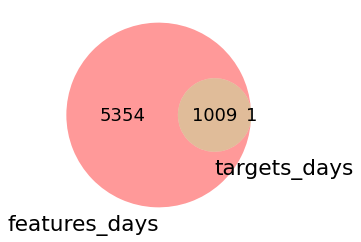

In [39]:
# do we have enough overlap with respect to 'friday_date'?
venn2([
    set(feature_df['friday_date'].astype(str).unique().tolist())
    , set(targets['friday_date'].astype(str).unique().tolist())
], set_labels=('features_days', 'targets_days'))

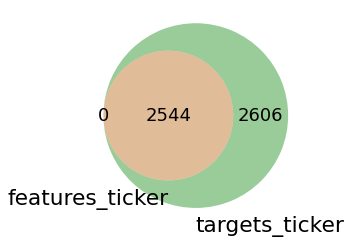

In [40]:
# do we have enough overlap with respect to 'ticker'?
venn2([
    set(feature_df['ticker'].astype(str).unique().tolist())
    , set(targets['ticker'].astype(str).unique().tolist())
], set_labels=('features_ticker', 'targets_ticker'))

In [41]:
# merge
feature_df['friday_date'] = feature_df['friday_date'].astype(int)
targets['friday_date'] = targets['friday_date'].astype(int)

feature_df = feature_df.merge(
    targets,
    how='left',
    on=['friday_date', 'ticker']
)

print(feature_df.shape)
feature_df.tail()
#round305p: 68GB in memory

(13099343, 1269)


,close_return_10days,close_volatility_10days,close_MA_gap_10days,close_return_20days,close_volatility_20days,close_MA_gap_20days,close_return_40days,close_volatility_40days,close_MA_gap_40days,close_return_60days,...,lretHigh-Low,lretHigh/Mean,lretLow/Mean,lretVolume/Close,friday_date,ticker,bloomberg_ticker,data_type,target_4d,target_20d
13099338,-0.055237,8.046875,0.961426,-0.076965,11.804688,0.948242,-0.083435,9.164062,0.941406,-0.035370,...,0.003082,0.911133,1.023438,-4.275937,20220613,ZURN SW,NaN,NaN,NaN,NaN
13099339,-0.048584,8.046875,0.970215,-0.086121,11.804688,0.956543,-0.069702,9.164062,0.947266,-0.038757,...,0.004993,1.608398,0.000000,-2.537392,20220614,ZURN SW,NaN,NaN,NaN,NaN
13099340,-0.027176,8.046875,0.989258,-0.073486,11.804688,0.976074,-0.073486,9.164062,0.964844,-0.033783,...,0.006001,1.262695,0.942383,9.643451,20220615,ZURN SW,NaN,NaN,NaN,NaN
13099341,-0.054779,8.046875,0.962402,-0.097412,11.804688,0.949219,-0.081726,9.164062,0.935547,-0.073059,...,0.012161,0.895508,1.401367,-2.751345,20220616,ZURN SW,NaN,NaN,NaN,NaN
13099342,-0.063477,8.046875,0.959961,-0.108093,11.804688,0.945801,-0.100830,9.164062,0.929688,-0.087158,...,-0.014175,1.522461,0.485352,644.141357,20220617,ZURN SW,NaN,NaN,NaN,NaN


In [42]:
# save (just to make sure that we are on the safe side if yfinance is dead some day...)
#feature_df.to_pickle(f'{CFG.OUTPUT_DIR}/feature_df.pkl')
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13099343 entries, 0 to 13099342
Columns: 1269 entries, close_return_10days to target_20d
dtypes: bool(10), float16(339), float32(907), float64(2), int64(1), int8(7), object(3)
memory usage: 53.4+ GB


We now have a merged features + target table! It seems like we are ready for modeling.

# Modeling
Yay, finally!

Here let's use XGBoost. 

The hyperparameters are derived from the Integration-Test, which is an example yet a strong baseline for the Numerai Tournament.

In [43]:
target = 'target_20d'
if 'target_20d' not in feature_df.columns.values.tolist():
    print('No target 20d exists...using target_4d instead...')
    target = 'target'
drops = ['data_type', 'target_4d', 'target_20d', 'friday_date', 'ticker', 'bloomberg_ticker']
features = [f for f in feature_df.columns.values.tolist() if f not in drops]

logger.info('{:,} features: {}'.format(len(features), features))

1,263 features: ['close_return_10days', 'close_volatility_10days', 'close_MA_gap_10days', 'close_return_20days', 'close_volatility_20days', 'close_MA_gap_20days', 'close_return_40days', 'close_volatility_40days', 'close_MA_gap_40days', 'close_return_60days', 'close_volatility_60days', 'close_MA_gap_60days', 'close_return_80days', 'close_volatility_80days', 'close_MA_gap_80days', 'close_return_90days', 'close_volatility_90days', 'close_MA_gap_90days', 'close_return_100days', 'close_volatility_100days', 'close_MA_gap_100days', 'close_return_110days', 'close_volatility_110days', 'close_MA_gap_110days', 'close_return_120days', 'close_volatility_120days', 'close_MA_gap_120days', 'vol_Volume_return_2days', 'vol_Volume_return_abs_2days', 'vol_Volume_volatility_2days', 'vol_Volume_MA_gap_2days', 'vol_Volume_return_18days', 'vol_Volume_return_abs_18days', 'vol_Volume_volatility_18days', 'vol_Volume_MA_gap_18days', 'vol_Volume_return_19days', 'vol_Volume_return_abs_19days', 'vol_Volume_volatilit

In [44]:
# fill nan
#feature_df.fillna(method='ffill', inplace=True) # safe fillna method for a forecasting task
#feature_df.fillna(method='bfill', inplace=True) # just in case ... making sure no nan
#clean DF


In [45]:
%%time
# train-valid split
train_set = {
    'X': feature_df.query('data_type == "train"')[features], 
    'y': feature_df.query('data_type == "train"')[target].astype(np.float64)
}
val_df = feature_df.query('data_type == "validation"').dropna().copy()
val_set = {
    'X': val_df[features], 
    'y': val_df[target].astype(np.float64)
}

assert train_set['y'].isna().sum() == 0
assert val_set['y'].isna().sum() == 0
#round305p:115GB in memory
#round305p run11: 125 in memory 15gb swap

CPU times: user 28.6 s, sys: 15.2 s, total: 43.7 s
Wall time: 44.1 s


In [46]:
%%time
# same parameters of the Integration-Test
import joblib

from sklearn import utils, metrics
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import operator

params = {
    'booster':'gbtree',
    'eta':0.01,
    'min_child_weight':1,
    'objective': 'reg:squarederror',#'multi:softmax',#'multi:softpred', 'objective': 'reg:squarederror'
    'eval_metric': 'rmse',
    'colsample_bytree': 0.1,                 
    'learning_rate': 0.01,
    'max_depth': 5,
    #'num_class':10,
    'gamma':0.01,
    #'subsample':0.9,
    'lambda':1,
    'alpha':0.00,
    'seed': 46,
    #'n_estimators': 3000,
    #'tree_method': 'gpu_hist' # if you want to use GPU ...
}
#Store params with neptune.ai model register
if neptune_switch == 1:
    run["parameters"] = params
    npt_callback = NeptuneCallback(run=run)
#Neptune code for xgboost
dtrain = xgb.DMatrix(train_set['X'], label=train_set['y'])
dval = xgb.DMatrix(val_set['X'], label=val_set['y'])
evals = [(dtrain, "train"), (dval, "valid")]

# You can also use Neptune with XGBoost scikit-learn API
# Check the user guide in the documentation for more details:
# https://docs.neptune.ai/integrations-and-supported-tools/model-training/xgboost


if neptune_switch == 0:
    xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=30,
    evals=evals,
    callbacks=[
        #npt_callback,
        xgb.callback.LearningRateScheduler(lambda epoch: 0.99 ** epoch),
        ],
    )
if neptune_switch == 1:
    xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=80,
        evals=evals,
        callbacks=[
            npt_callback,
            xgb.callback.LearningRateScheduler(lambda epoch: 0.99 ** epoch),
        ],
    )

# define 
model = xgb.XGBRegressor(**params)

# fit
model.fit(
    train_set['X'], train_set['y'], 
    eval_set=[(val_set['X'], val_set['y'])],
    verbose=100, 
    early_stopping_rounds=20,
)

# save model
joblib.dump(model, f'{CFG.OUTPUT_DIR}/xgb_model_val.pkl')
logger.info('xgb model with early stopping saved!')

# feature importance
importance = model.get_booster().get_score(importance_type='gain')
importance = sorted(importance.items(), key=operator.itemgetter(1))
feature_importance_df = pd.DataFrame(importance, columns=['features', 'importance'])
#round305 ehmac: 0.21349 using 62GB
#round305p ehmac: 125GB in memory 0.21289
#round305p node2: 260GB
#round315 node1: 0.21285
#round316 node1 0.21348
#round318 node1: at 300 0.21324
#round319:run1,max_depth:5,0.2387,run2:'learning_rate':0.01,loss:0.23871; run3'learning_rate':0.001,rmse:0.23869,4min
#run4'max_depth:7,colsample_bytree:0.1,0.24,4min,run5'max_depth:8,colsample_bytree:0.2,gamma:0.03,learning_rate:0.01,rmse:0.23872,4min
#run6'objective':'multi:softmax',eta:0.01,max_depth:5,num_class:5,mlogloss:1.48,run7,eta:0.3'objective': 'reg:squarederror',rmse:0.23872
#run8'objective':'multi:softprob',colsample_bythree:0.5,learning_rate:0.05,'num_class':10,mlogloss:,boost_round:80,
#round321:rmse 0.19967

[0]	train-rmse:0.20483	valid-rmse:0.19975
[1]	train-rmse:0.20458	valid-rmse:0.19980
[2]	train-rmse:0.20448	valid-rmse:0.19986
[3]	train-rmse:0.20429	valid-rmse:0.19996
[4]	train-rmse:0.20416	valid-rmse:0.20022
[5]	train-rmse:0.20411	valid-rmse:0.20023
[6]	train-rmse:0.20400	valid-rmse:0.20029
[7]	train-rmse:0.20390	valid-rmse:0.20037
[8]	train-rmse:0.20383	valid-rmse:0.20040
[9]	train-rmse:0.20371	valid-rmse:0.20051
[10]	train-rmse:0.20362	valid-rmse:0.20055
[11]	train-rmse:0.20351	valid-rmse:0.20075
[12]	train-rmse:0.20341	valid-rmse:0.20079
[13]	train-rmse:0.20336	valid-rmse:0.20080
[14]	train-rmse:0.20324	valid-rmse:0.20087
[15]	train-rmse:0.20315	valid-rmse:0.20092
[16]	train-rmse:0.20310	valid-rmse:0.20094
[17]	train-rmse:0.20303	valid-rmse:0.20097
[18]	train-rmse:0.20295	valid-rmse:0.20101
[19]	train-rmse:0.20289	valid-rmse:0.20104
[20]	train-rmse:0.20283	valid-rmse:0.20108
[21]	train-rmse:0.20277	valid-rmse:0.20110
[22]	train-rmse:0.20272	valid-rmse:0.20120
[23]	train-rmse:0.202

xgb model with early stopping saved!
2022-06-18 23:37:33,066 INFO __main__: xgb model with early stopping saved!


CPU times: user 2h 6min 56s, sys: 3min, total: 2h 9min 57s
Wall time: 11min 23s


<AxesSubplot:xlabel='importance', ylabel='features'>

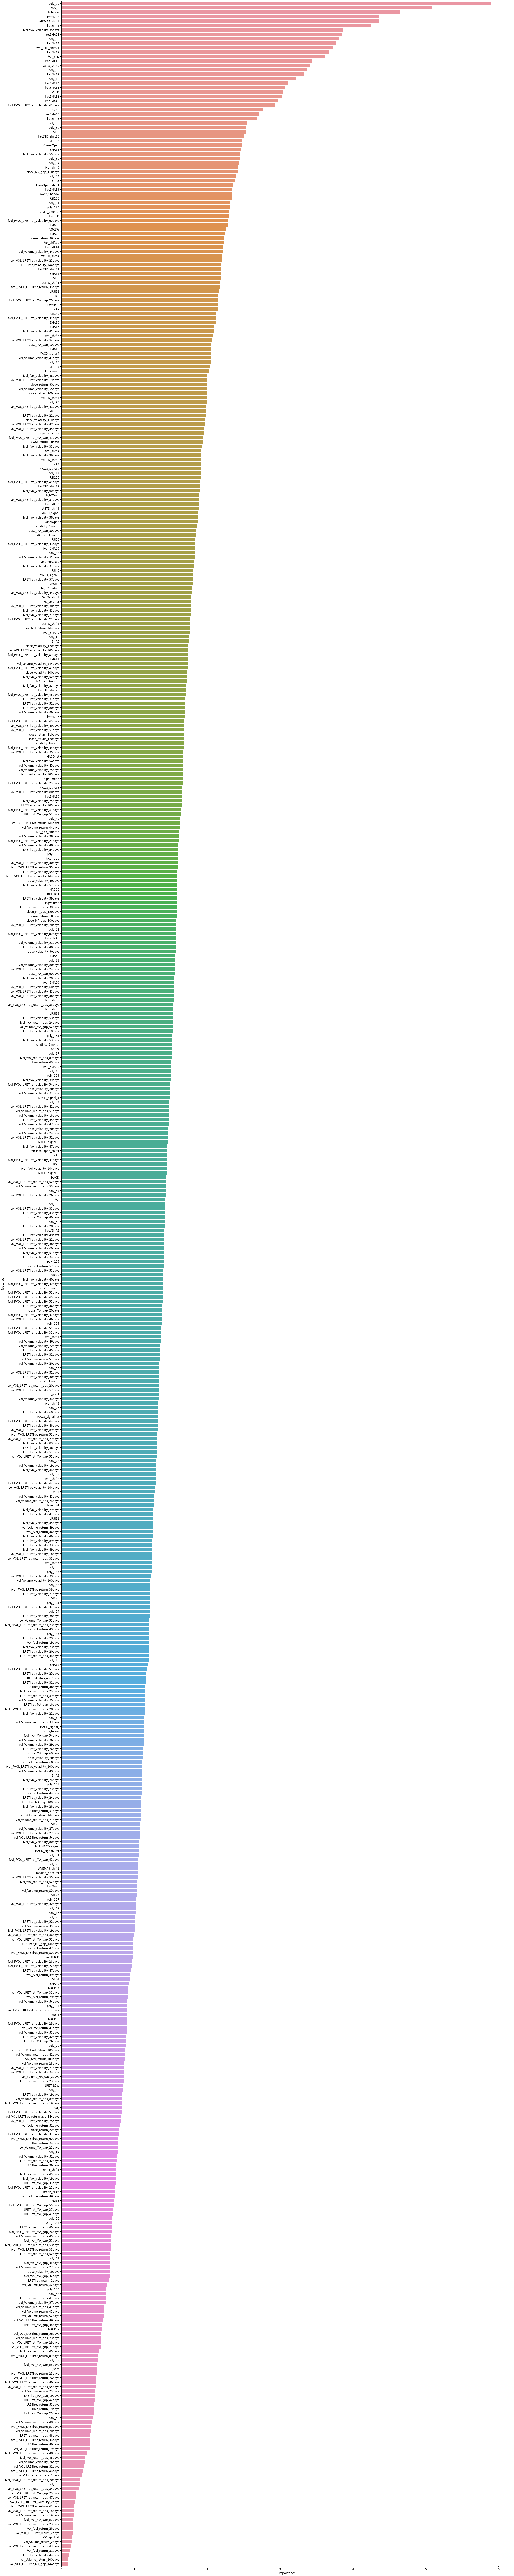

In [47]:
# feature importance
fig, ax = plt.subplots(1, 1, figsize=(48, 280))
sns.barplot(
    x='importance', 
    y='features', 
    data=feature_importance_df.sort_values(by='importance', ascending=False),
    ax=ax
)

# Validation Score
The following snipets are derived from 

https://colab.research.google.com/drive/1ECh69C0LDCUnuyvEmNFZ51l_276nkQqo#scrollTo=tTBUzPep2dm3

Let's see how good our model predictions on the validation data are.


In [48]:
# https://colab.research.google.com/drive/1ECh69C0LDCUnuyvEmNFZ51l_276nkQqo#scrollTo=tTBUzPep2dm3

def score(df, target_name=target, pred_name='prediction'):
    '''Takes df and calculates spearm correlation from pre-defined cols'''
    # method="first" breaks ties based on order in array
    return np.corrcoef(
        df[target_name],
        df[pred_name].rank(pct=True, method="first")
    )[0,1]

def run_analytics(era_scores):
    print(f"Mean Correlation: {era_scores.mean():.4f}")
    print(f"Median Correlation: {era_scores.median():.4f}")
    print(f"Standard Deviation: {era_scores.std():.4f}")
    print('\n')
    print(f"Mean Pseudo-Sharpe: {era_scores.mean()/era_scores.std():.4f}")
    print(f"Median Pseudo-Sharpe: {era_scores.median()/era_scores.std():.4f}")
    print('\n')
    print(f'Hit Rate (% positive eras): {era_scores.apply(lambda x: np.sign(x)).value_counts()[1]/len(era_scores):.2%}')

    era_scores.rolling(20).mean().plot(kind='line', title='Rolling Per Era Correlation Mean', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

    era_scores.cumsum().plot(title='Cumulative Sum of Era Scores', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()
    if neptune_switch == 1:
        run["eval/Mean_Correlation"] = era_scores.mean()
        run["eval/Median Correlation"] = era_scores.median()
        run["eval/Standard Deviation"] = era_scores.std()
        run["eval/Mean Pseudo-Sharpe"] = era_scores.mean()/era_scores.std()
        run["eval/Median Pseudo-Sharpe"] = era_scores.mean()/era_scores.std()
        run["eval/Hit Rate (% positive eras)"] = era_scores.apply(lambda x: np.sign(x)).value_counts()[1]/len(era_scores)

Mean Correlation: 0.0280
Median Correlation: 0.0256
Standard Deviation: 0.0313


Mean Pseudo-Sharpe: 0.8944
Median Pseudo-Sharpe: 0.8176


Hit Rate (% positive eras): 85.45%


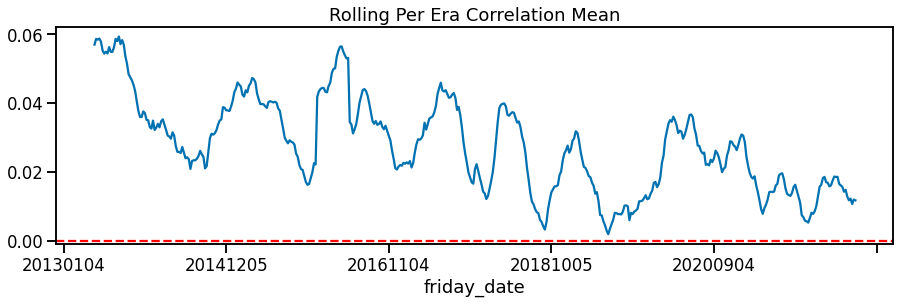

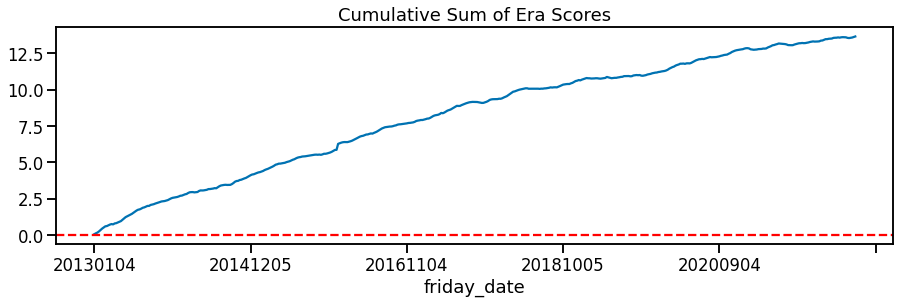

CPU times: user 2min 12s, sys: 44.7 s, total: 2min 57s
Wall time: 2min 15s


In [49]:
%%time
# prediction for the validation set
valid_sub = val_df[drops].copy()
valid_sub['prediction'] = model.predict(val_set['X'])

# compute score
val_era_scores = valid_sub.copy()
val_era_scores['friday_date'] = val_era_scores['friday_date'].astype(str)
val_era_scores = val_era_scores.loc[val_era_scores['prediction'].isna() == False].groupby(['friday_date']).apply(score)
run_analytics(val_era_scores)

In [50]:
napi = numerapi.NumerAPI(verbosity="info")
if internet==1:
    current_ds = napi.get_current_round()
current_ds=319
print('Current round: ',current_ds)

valid_sub.to_csv(f"analysis_90pct_1864_2_{current_ds}.csv")

#stop neptune.ai run
if neptune_switch == 1:
    run.stop()

Current round:  319


## round 321

Mean Correlation: 0.0280

Median Correlation: 0.0256

Standard Deviation: 0.0313

Mean Pseudo-Sharpe: 0.8944

Median Pseudo-Sharpe: 0.8176

Hit Rate (% positive eras): 85.45%

## round 319

run1 (1866 stocks short periods):

Mean Correlation: 0.0189

Median Correlation: 0.0181

Standard Deviation: 0.0371

Mean Pseudo-Sharpe: 0.5104

Median Pseudo-Sharpe: 0.4886

Hit Rate (% positive eras): 68.52%

run2 softmax

Mean Correlation: 0.0086

Median Correlation: 0.0060

Standard Deviation: 0.0363

Mean Pseudo-Sharpe: 0.2364

Median Pseudo-Sharpe: 0.1648

Hit Rate (% positive eras): 58.85%

run3 

Mean Correlation: 0.0274

Median Correlation: 0.0256

Standard Deviation: 0.0311

Mean Pseudo-Sharpe: 0.8824

Median Pseudo-Sharpe: 0.8256

Hit Rate (% positive eras): 85.19%

## round 318

Mean Correlation: 0.0366

Median Correlation: 0.0363

Standard Deviation: 0.0323

Mean Pseudo-Sharpe: 1.1336

Median Pseudo-Sharpe: 1.1228

Hit Rate (% positive eras): 89.90%

## round 317

Mean Correlation: 0.0371

Median Correlation: 0.0373

Standard Deviation: 0.0290

Mean Pseudo-Sharpe: 1.2763

Median Pseudo-Sharpe: 1.2827

Hit Rate (% positive eras): 90.25%


## round 316

Mean Correlation: 0.0384

Median Correlation: 0.0370

Standard Deviation: 0.0287

Mean Pseudo-Sharpe: 1.3401

Median Pseudo-Sharpe: 1.2889

Hit Rate (% positive eras): 91.49%


## round 305

#result to beat

Mean Correlation: 0.0140

Median Correlation: 0.0131

Standard Deviation: 0.0228

Mean Pseudo-Sharpe: 0.6110

Median Pseudo-Sharpe: 0.5747

Hit Rate (% positive eras): 74.95%

Run 2

Mean Correlation: 0.0194

Median Correlation: 0.0187

Standard Deviation: 0.0259

Mean Pseudo-Sharpe: 0.7486

Median Pseudo-Sharpe: 0.7245

Hit Rate (% positive eras): 83.65%

Sharpe: 0.9321

Sharpe200: 0.1692

APY: 384.5%

APY200: 80.8

run3:

APY200: 41.6% 

Sharpe200: 0.1201

run 4:

Mean Correlation: 0.0189

Median Correlation: 0.0180

Standard Deviation: 0.0216

Mean Pseudo-Sharpe: 0.8775

Median Pseudo-Sharpe: 0.8325

Hit Rate (% positive eras): 82.38%

run 5:

Mean Correlation: 0.0166

Median Correlation: 0.0149

Standard Deviation: 0.0265

Mean Pseudo-Sharpe: 0.6278

Median Pseudo-Sharpe: 0.5630

Hit Rate (% positive eras): 74.10%

Sharpe: 0.0885

APY: 20.6%

run 6:

Mean Correlation: 0.0172

Median Correlation: 0.0161

Standard Deviation: 0.0263

Mean Pseudo-Sharpe: 0.6531

Median Pseudo-Sharpe: 0.6132

Hit Rate (% positive eras): 74.31%

run 7:

Mean Correlation: 0.0122

Median Correlation: 0.0119

Standard Deviation: 0.0310

Mean Pseudo-Sharpe: 0.3948

Median Pseudo-Sharpe: 0.3852

Hit Rate (% positive eras): 70.06%

run8:

Mean Correlation: 0.0224

Median Correlation: 0.0220

Standard Deviation: 0.0314

Mean Pseudo-Sharpe: 0.7124

Median Pseudo-Sharpe: 0.7000

Hit Rate (% positive eras): 80.68%

Sharpe:0.8457

Sharpe200: 0.0773

APY: 385%

APY200: 15.1%

run8:

Mean Correlation: 0.0220

Median Correlation: 0.0204

Standard Deviation: 0.0328

Mean Pseudo-Sharpe: 0.6716

Median Pseudo-Sharpe: 0.6239

Hit Rate (% positive eras): 79.83%

Sharpe:0.8457

Sharpe200: 0.0773

APY: 385%

APY200: 15.1%

run9:

APY: 359

Sharpe: 0.8360

APY200: -21%

run10:

Mean Correlation: 0.0242

Median Correlation: 0.0228

Standard Deviation: 0.0326

Mean Pseudo-Sharpe: 0.7435

Median Pseudo-Sharpe: 0.7001

Hit Rate (% positive eras): 86.41%

Sharpe: 0.8705

Sharpe200: 0.1307

APY: 406.7%

APY200: 49.2%

run11:

Mean Correlation: 0.0380

Median Correlation: 0.0388

Standard Deviation: 0.0335

Mean Pseudo-Sharpe: 1.1342

Median Pseudo-Sharpe: 1.1577

Hit Rate (% positive eras): 93.63%

Sharpe: 1.3736

Sharpe200: 0.2047

APY: 1211.6%

APY200: 118.1%


# Submission
Let's use this trained model to make a submission for the Numerai Signals.

Note that, again, yfinance data is not complete. Sometimes there is no recent data available for many tickers;(

We need at least 5 tickers for a successful submission. Let's first check if we have at least 5 tickers in which the recent friday_date for them is indeed the recent friday date.

In [51]:
# do we have at least 5 tickers, whose the latest date matches the recent friday?
ticker_date_df = feature_df.groupby('ticker')['friday_date'].max().reset_index()
if len(ticker_date_df.loc[ticker_date_df['friday_date'] == recent_friday]) >= 5:
    ticker_date_df = ticker_date_df.loc[ticker_date_df['friday_date'] == recent_friday]
else: # use dates later than the second last friday
    ticker_date_df = ticker_date_df.loc[ticker_date_df['friday_date'] == recent_friday2]
    recent_friday = recent_friday2
    
print(len(ticker_date_df))
ticker_date_df

2536


,ticker,friday_date
0,000060 KS,20220617
1,000080 KS,20220617
2,000100 KS,20220617
3,000120 KS,20220617
4,000270 KS,20220617
...,...,...
2539,YUM,20220617
2540,ZBH,20220617
2541,ZBRA,20220617
2542,ZION,20220617


Good! That's fairly enough. So we only perform the inference on those tickers and submit!

In [52]:
# live sub
feature_df.loc[feature_df['friday_date'] == recent_friday, 'data_type'] = 'live'
test_sub = feature_df.query('data_type == "live"')[drops].copy()
test_sub['prediction'] = model.predict(feature_df.query('data_type == "live"')[features])

logger.info(test_sub.shape)
test_sub.head()

(2536, 7)
2022-06-18 23:40:08,193 INFO __main__: (2536, 7)


,data_type,target_4d,target_20d,friday_date,ticker,bloomberg_ticker,prediction
5116,live,NaN,NaN,20220617,000060 KS,NaN,0.504890
10233,live,NaN,NaN,20220617,000080 KS,NaN,0.496838
15350,live,NaN,NaN,20220617,000100 KS,NaN,0.501162
20467,live,NaN,NaN,20220617,000120 KS,NaN,0.500228
25583,live,NaN,NaN,20220617,000270 KS,NaN,0.504337


Current round:  319
Most recent Friday: 20220617
Second most recent Friday: 20220610
2536


(2536, 7)
2022-06-18 23:40:10,849 INFO __main__: (2536, 7)


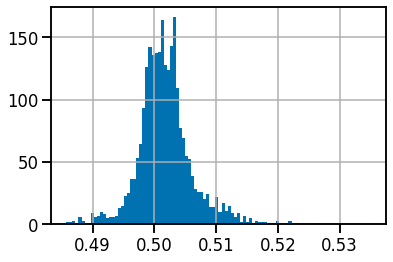

In [53]:
### submission
from datetime import datetime
#today = datetime.now().strftime('%Y-%m-%d')
today = '2022'

napi = numerapi.NumerAPI(verbosity="info")

print('Current round: ',current_ds)
# recent friday date?
recent_friday = datetime.now() + relativedelta(weekday=FR(-1))
recent_friday = int(recent_friday.strftime('%Y%m%d'))
print(f'Most recent Friday: {recent_friday}')
recent_friday2 = datetime.now() + relativedelta(weekday=FR(-2))
recent_friday2 = int(recent_friday2.strftime('%Y%m%d'))
print(f'Second most recent Friday: {recent_friday2}')
# do we have at least 5 tickers, whose the latest date matches the recent friday?
ticker_date_df = feature_df.groupby('ticker')['friday_date'].max().reset_index()
if len(ticker_date_df.loc[ticker_date_df['friday_date'] == recent_friday]) >= 5:
    ticker_date_df = ticker_date_df.loc[ticker_date_df['friday_date'] == recent_friday]
else: # use dates later than the second last friday
    ticker_date_df = ticker_date_df.loc[ticker_date_df['friday_date'] == recent_friday2]
    recent_friday = recent_friday2
    
print(len(ticker_date_df))
ticker_date_df
# live sub
feature_df.loc[feature_df['friday_date'] == recent_friday, 'data_type'] = 'live'
test_sub = feature_df.query('data_type == "live"')[drops].copy()
test_sub['prediction'] = model.predict(feature_df.query('data_type == "live"')[features])

logger.info(test_sub.shape)
test_sub.head()
#print("Current date and time: ",str(datetime.datetime.now()))
test_sub['prediction'].hist(bins=100)
def submit_signal(sub: pd.DataFrame, public_id: str, secret_key: str, slot_name: str):
    """
    submit numerai signals prediction
    """
    # setup private API
    napi = numerapi.SignalsAPI(public_id, secret_key)
    
    # write predictions to csv
    model_id = napi.get_models()[f'{slot_name}']
    filename = f"sub_{model_id}.csv"
    sub.to_csv(filename, index=False)
    
    # submit
    submission = napi.upload_predictions(filename, model_id=model_id)
    print(f'Submitted : {slot_name}!')
    
# concat valid and test 
sub = pd.concat([valid_sub, test_sub], ignore_index=True)

# rename to 'signal'
sub.rename(columns={'prediction': 'signal'}, inplace=True)

# select necessary columns
sub = sub[['ticker', 'friday_date', 'data_type', 'signal']]

public_id = '<Your Numerai API ID>'
secret_key = '<Your Numerai Secret Key>'
slot_name = '<Your Numerai Signals Submission Slot Name>'
# submit_signal(sub, public_id, secret_key, slot_name) # uncomment if you submit

# save 
sub.to_csv(f'../{current_ds}_submission_xgb_3_{today}.csv', index=False)

<AxesSubplot:>

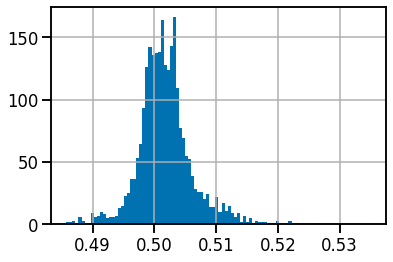

In [54]:
# histogram of prediction
test_sub['prediction'].hist(bins=100)

Let's submit! What is good with the Numerai Signals is that if you submit your predictions on the validation data, on the website, you can get more information about your model performance such as APY.

Due to the change in the NumerAPI, now we need to split our submission file into the validation only one for getting diagnostics and the rest for the weekly submission. 

In [55]:
# To submit, you need to have Numerai account and have API's id and secret key. Also you need to have at least one (numerai signals') model slot.
# public_id = '<Your Numerai API ID>'
# secret_key = '<Your Numerai Secret Key>'
# slot_name = '<Your Numerai Signals Submission Slot Name>'

# The following is mine. You cannot use them so replace them with yours:D
#from kaggle_secrets import UserSecretsClient
#user_secrets = UserSecretsClient()
#public_id = user_secrets.get_secret("public_id")
#secret_key = user_secrets.get_secret("secret_key")
#slot_name = 'VANDEMONIA'

In [56]:
"""
submit numerai signals prediction
"""
# setup private API
#napi = numerapi.SignalsAPI(public_id, secret_key)
#model_id = napi.get_models()[f'{slot_name.lower()}']

# submit to get diagnostics
filename = f"example_sub_val{model_id}.csv"
test_sub.query('data_type == "test"').to_csv(filename, index=False)
#napi.upload_diagnostics(filename, model_id=model_id)
#print('Validation prediction uploaded for diagnostics!')

# submit
filename = f"example_sub.csv"
test_sub.to_csv(filename, index=False)

NameError: name 'model_id' is not defined

In [ ]:
def submit_signal(sub: pd.DataFrame, public_id: str, secret_key: str, slot_name: str):
    """
    submit numerai signals prediction
    """
    # setup private API
    napi = numerapi.SignalsAPI(public_id, secret_key)
    model_id = napi.get_models()[f'{slot_name.lower()}']
    
    # submit to get diagnostics
    filename = f"example_sub_val{model_id}.csv"
    sub.query('data_type == "validation"').to_csv(filename, index=False)
    napi.upload_diagnostics(filename, model_id=model_id)
    print('Validation prediction uploaded for diagnostics!')
    
    # submit
    filename = f"example_sub{model_id}.csv"
    sub.to_csv(filename, index=False)
    try:
        napi.upload_predictions(filename, model_id=model_id)
        print(f'Submitted : {slot_name}!')
    except Exception as e:
        print(f'Submission failure: {e}')
    
# concat valid and test 
sub = pd.concat([valid_sub, test_sub], ignore_index=True)

# rename to 'signal'
sub.rename(columns={'prediction': 'signal'}, inplace=True)

# select necessary columns
sub = sub[['ticker', 'friday_date', 'data_type', 'signal']]

# submit
submit_signal(sub, public_id, secret_key, slot_name)

**Weekly submission is only accepted between 18:00 on Saturday ~ 14:30 on Monday (UTC)**, but you can always upload your validation prediction to see the diagnostics in the [Numerai website](https://signals.numer.ai/models).

By clicking "More" --> "Diagnostics" in your model slot, you can see a pretty figure summarizing your validation scores. The following is from this notebook. Looks good, doesn't it!?


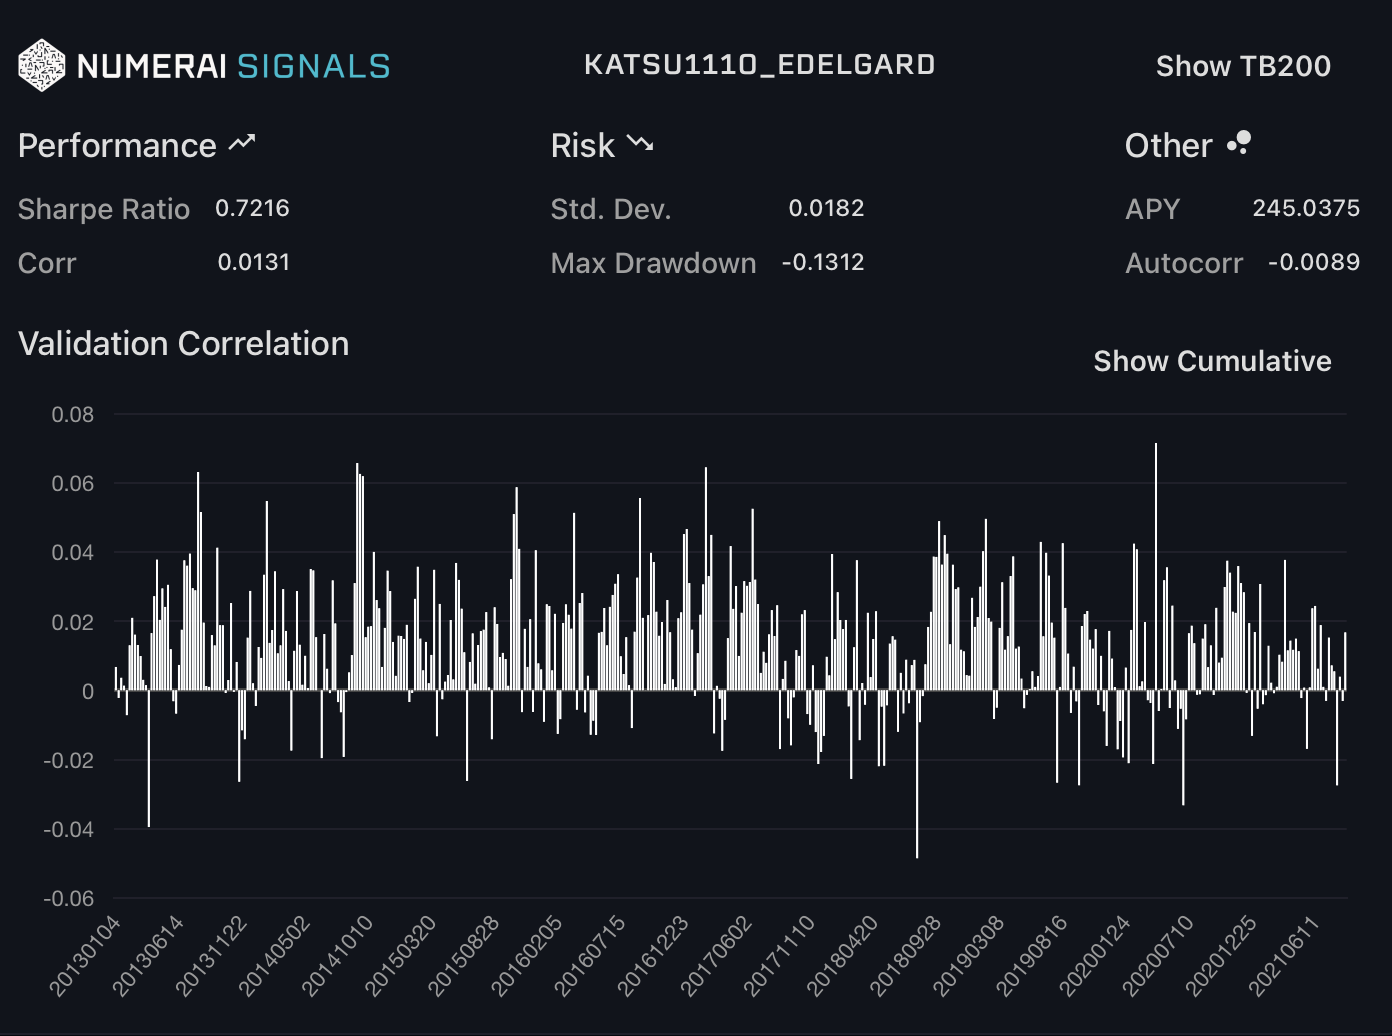

In [ ]:
print(sub.shape)
sub.head()

In [ ]:
sub.tail()

ALL DONE!

Of course, this is just another starter, and there are plenty rooms left to be improved.

- Feature engineering (more stock price, volume features? Be careful for leaks and non-stationality)
- Modeling (another model? another validation strategy? training period?)
- Target (Should we simply use the historical targets? Can we make a new one?)
- Dataset (is yfinance sufficient for stable weekly performance?)

...potentially more...


Made Money with this Starter? Consider support me with NMR:D

(My NMR address)
0x0000000000000000000000000000000000021ae9

Have fun with Numerai Signals!